In [50]:
import pandas as pd
import json
from shapely import wkt, wkb
from shapely.geometry import Polygon, MultiPolygon
pd.set_option('display.max_colwidth', 400)

In [16]:
#логер
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [17]:
df = pd.read_csv('../data/localities.csv')
df.shape

(1576, 13)

Поиск дубликатов адресов

In [20]:
group = df.groupby('address').count().reset_index().sort_values('poly', ascending=False)
queries = df.loc[df.address.isin(group.loc[group['query']>1, 'address'].to_list()), 'query'].to_list()

In [101]:
df.loc[df['query'].isin(queries)][['name', 'type','query', 'address']].sort_values('address')

,name,type,query,address
1564,Братск,город,Братск иркутская область,"Россия, Иркутская область, Братск"
1566,Правобережный,район,Правобережный район Братск иркутская...,"Россия, Иркутская область, Братск"
765,Тулюшка,село сельский,Тулюшка село Куйтунский иркутская об...,"Россия, Иркутская область, Куйтунски..."
766,Тулюшка,поселок ж.д. станции сельский,Тулюшка поселок Куйтунский иркутская...,"Россия, Иркутская область, Куйтунски..."
902,Шеберта,село сельский,Шеберта село Нижнеудинский иркутская...,"Россия, Иркутская область, Нижнеудин..."
903,Шеберта,поселок ж.д. станции сельский,Шеберта поселок Нижнеудинский иркутс...,"Россия, Иркутская область, Нижнеудин..."
926,Мельхитуй,деревня сельский,Мельхитуй деревня Нукутский иркутска...,"Россия, Иркутская область, Нукутский..."
927,Мельхитуй,деревня сельский,Мельхитуй деревня Нукутский иркутска...,"Россия, Иркутская область, Нукутский..."
1131,Туманшет,деревня сельский,Туманшет деревня Тайшетский иркутска...,"Россия, Иркутская область, Тайшетски..."
1132,Туманшет,поселок ж.д. станции сельский,Туманшет поселок Тайшетский иркутска...,"Россия, Иркутская область, Тайшетски..."


# Изменение данных вручную

In [54]:
df.loc[1151, 'query'] = 'Александровка деревня Тулунский иркутская область Бурхунское'
df.loc[1151, 'address'] = "Россия, Иркутская область, Тулунский район, деревня Александровка"
df.loc[1151, 'geometry'] = '''
  [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            100.697424,
            54.790772999999994
          ],
          [
            100.70199199999999,
            54.791995
          ],
          [
            100.70411999999999,
            54.792680999999995
          ],
          [
            100.70560499999999,
            54.793113999999996
          ],
          [
            100.707042,
            54.793589999999995
          ],
          [
            100.70814,
            54.793853
          ],
          [
            100.710703,
            54.794635
          ],
          [
            100.714151,
            54.79539
          ],
          [
            100.714823,
            54.794546999999994
          ],
          [
            100.71526399999999,
            54.794205999999996
          ],
          [
            100.716088,
            54.793346
          ],
          [
            100.712391,
            54.792068
          ],
          [
            100.70826699999999,
            54.790855
          ],
          [
            100.70867,
            54.790368
          ],
          [
            100.709373,
            54.789657
          ],
          [
            100.70987099999999,
            54.788106
          ],
          [
            100.70652199999999,
            54.787867999999996
          ],
          [
            100.704903,
            54.78906
          ],
          [
            100.704416,
            54.789561
          ],
          [
            100.69968,
            54.788509999999995
          ]
        ]
      ]
    }
  ]
'''

In [121]:
def manual_changing(query, address, geometry):            
    df.loc[df['query'] == query, 'address'] = address
    df.loc[df['query'] == query, 'geometry'] = str(json.loads(geometry)['geometries'])
    df.loc[df['query'] == query, 'valid'] = 1

In [122]:
query = ['Жигалово рабочий Жигаловский иркутская область',
 'Залари рабочий Заларинский иркутская область',
 'Мамуркова заимка иркутская область',
 'Хор-Бутырина участок иркутская область',
 'Тулюшка поселок Куйтунский иркутская область',
 'Ук рабочий иркутская область',
 'Шеберта поселок Нижнеудинский иркутская область',
 'Новонукутский поселок Нукутский иркутская область',
 'Байкал (порт) поселок иркутская область',
 'Туманшет поселок Тайшетский иркутская область',
 'Заусаево деревня иркутская область']
address = ['Россия, Иркутская область, поселок городского типа Жигалово',
          "Россия, Иркутская область, посёлок городского типа Залари",
          "Россия, Иркутская область, Заларинский район, посёлок городского типа Тыреть 1-я, заимка Мамуркова",
          "Россия, Иркутская область, Заларинский район, посёлок Хор-Бутырина",
          "Россия, Иркутская область, Куйтунский район, посёлок железнодорожной станции Тулюшка",
          "Россия, Иркутская область, Нижнеудинский район, Уковское муниципальное образование, рабочий посёлок Ук",
          "Россия, Иркутская область, Нижнеудинский район, Шебертинское муниципальное образование, поселок железнодорожной станции Шеберта",
          "Россия, Иркутская область, Нукутский район, поселок Новонукутский",
           "Россия, Иркутская область, Слюдянский район, поселок Байкал (порт)",
           "Россия, Иркутская область, Тайшетский район, поселок ж/д станции Туманшет",
           "Россия, Иркутская область, Тулунский район, деревня Заусаева",
          ]
geometry = ['''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            105.096769,
            54.827926
          ],
          [
            105.09570199999999,
            54.828919
          ],
          [
            105.095249,
            54.8292
          ],
          [
            105.09654599999999,
            54.830262999999995
          ],
          [
            105.098272,
            54.829423
          ],
          [
            105.100033,
            54.828416999999995
          ],
          [
            105.10274199999999,
            54.826192999999996
          ],
          [
            105.104176,
            54.823615999999994
          ],
          [
            105.103686,
            54.823122
          ],
          [
            105.10345799999999,
            54.822123
          ],
          [
            105.103645,
            54.820285
          ],
          [
            105.103296,
            54.819500999999995
          ],
          [
            105.103494,
            54.81916
          ],
          [
            105.104726,
            54.818253999999996
          ],
          [
            105.10393599999999,
            54.817901
          ],
          [
            105.098638,
            54.820184999999995
          ],
          [
            105.09683299999999,
            54.821870999999994
          ],
          [
            105.09884199999999,
            54.823451
          ],
          [
            105.09737899999999,
            54.825381
          ],
          [
            105.095569,
            54.827028999999996
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            105.19398699999999,
            54.812279
          ],
          [
            105.198065,
            54.812565
          ],
          [
            105.198808,
            54.811913999999994
          ],
          [
            105.20283599999999,
            54.812546
          ],
          [
            105.203666,
            54.811775999999995
          ],
          [
            105.20626899999999,
            54.808574
          ],
          [
            105.211325,
            54.803703
          ],
          [
            105.207899,
            54.801981999999995
          ],
          [
            105.202107,
            54.803131
          ],
          [
            105.20069199999999,
            54.804154
          ],
          [
            105.195258,
            54.804263
          ],
          [
            105.196698,
            54.805552
          ],
          [
            105.19551399999999,
            54.805448
          ],
          [
            105.192365,
            54.804733999999996
          ],
          [
            105.18696299999999,
            54.804652
          ],
          [
            105.186611,
            54.805301
          ],
          [
            105.184547,
            54.805614
          ],
          [
            105.18343399999999,
            54.806098
          ],
          [
            105.182222,
            54.806228999999995
          ],
          [
            105.182249,
            54.806674
          ],
          [
            105.184748,
            54.807567
          ],
          [
            105.187084,
            54.808181999999995
          ],
          [
            105.18753799999999,
            54.808932
          ],
          [
            105.18936699999999,
            54.810285
          ],
          [
            105.19005299999999,
            54.811211
          ],
          [
            105.190123,
            54.812172999999994
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            105.165441,
            54.816410999999995
          ],
          [
            105.167963,
            54.815135
          ],
          [
            105.16993199999999,
            54.813447
          ],
          [
            105.169967,
            54.812704
          ],
          [
            105.170485,
            54.811381
          ],
          [
            105.17190699999999,
            54.809582
          ],
          [
            105.173656,
            54.808037
          ],
          [
            105.174972,
            54.807202999999994
          ],
          [
            105.176324,
            54.806649
          ],
          [
            105.178479,
            54.806498
          ],
          [
            105.17801999999999,
            54.804668
          ],
          [
            105.18107599999999,
            54.804437
          ],
          [
            105.189145,
            54.803523
          ],
          [
            105.19337499999999,
            54.803850999999995
          ],
          [
            105.19752,
            54.80365
          ],
          [
            105.197587,
            54.802555999999996
          ],
          [
            105.198645,
            54.799814
          ],
          [
            105.19970599999999,
            54.799552999999996
          ],
          [
            105.198212,
            54.797818
          ],
          [
            105.196429,
            54.797892999999995
          ],
          [
            105.19263,
            54.797796999999996
          ],
          [
            105.18886499999999,
            54.798066999999996
          ],
          [
            105.186549,
            54.796186999999996
          ],
          [
            105.187636,
            54.795887
          ],
          [
            105.18627199999999,
            54.794095999999996
          ],
          [
            105.18264099999999,
            54.794754
          ],
          [
            105.181074,
            54.792759
          ],
          [
            105.17836199999999,
            54.793316999999995
          ],
          [
            105.179531,
            54.795341
          ],
          [
            105.17817,
            54.795421
          ],
          [
            105.177143,
            54.794171
          ],
          [
            105.17457499999999,
            54.792784
          ],
          [
            105.172315,
            54.792248
          ],
          [
            105.16758,
            54.793827
          ],
          [
            105.16514699999999,
            54.795618999999995
          ],
          [
            105.163508,
            54.799229999999994
          ],
          [
            105.16219799999999,
            54.799796
          ],
          [
            105.158864,
            54.800306
          ],
          [
            105.155288,
            54.800751999999996
          ],
          [
            105.153033,
            54.798823
          ],
          [
            105.15137999999999,
            54.796785
          ],
          [
            105.149127,
            54.79524
          ],
          [
            105.140349,
            54.798142
          ],
          [
            105.13873799999999,
            54.796594999999996
          ],
          [
            105.137479,
            54.797204
          ],
          [
            105.141189,
            54.801216
          ],
          [
            105.134451,
            54.802569999999996
          ],
          [
            105.13238799999999,
            54.800948999999996
          ],
          [
            105.133698,
            54.799952999999995
          ],
          [
            105.131317,
            54.797123
          ],
          [
            105.127715,
            54.798603
          ],
          [
            105.12863399999999,
            54.799783999999995
          ],
          [
            105.124516,
            54.801835999999994
          ],
          [
            105.120334,
            54.805647
          ],
          [
            105.116013,
            54.811651999999995
          ],
          [
            105.11513199999999,
            54.812193
          ],
          [
            105.11660099999999,
            54.812611
          ],
          [
            105.119035,
            54.812621
          ],
          [
            105.122388,
            54.813151999999995
          ],
          [
            105.12177199999999,
            54.814493999999996
          ],
          [
            105.12133399999999,
            54.81501
          ],
          [
            105.12287599999999,
            54.815625999999995
          ],
          [
            105.124832,
            54.816142
          ],
          [
            105.127658,
            54.816728999999995
          ],
          [
            105.130411,
            54.816984
          ],
          [
            105.133262,
            54.816936999999996
          ],
          [
            105.135043,
            54.816748
          ],
          [
            105.137423,
            54.81624
          ],
          [
            105.13939099999999,
            54.816067999999994
          ],
          [
            105.14047599999999,
            54.815101999999996
          ],
          [
            105.142251,
            54.814879
          ],
          [
            105.14488899999999,
            54.814864
          ],
          [
            105.150267,
            54.814606
          ],
          [
            105.150415,
            54.815692999999996
          ],
          [
            105.150278,
            54.815937999999996
          ],
          [
            105.152299,
            54.816362999999996
          ],
          [
            105.15320799999999,
            54.816677999999996
          ],
          [
            105.15533599999999,
            54.817867
          ],
          [
            105.15681099999999,
            54.818247
          ],
          [
            105.15911299999999,
            54.818107999999995
          ],
          [
            105.162002,
            54.817487
          ],
          [
            105.16352599999999,
            54.817287
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            102.46377799999999,
            53.563156
          ],
          [
            102.46425699999999,
            53.563835999999995
          ],
          [
            102.471108,
            53.568833999999995
          ],
          [
            102.46971099999999,
            53.569573999999996
          ],
          [
            102.47009,
            53.569736999999996
          ],
          [
            102.46614799999999,
            53.572494
          ],
          [
            102.470827,
            53.574635
          ],
          [
            102.47363999999999,
            53.572953999999996
          ],
          [
            102.474414,
            53.573234
          ],
          [
            102.490759,
            53.564633
          ],
          [
            102.49409399999999,
            53.565867
          ],
          [
            102.49603599999999,
            53.566275999999995
          ],
          [
            102.49753899999999,
            53.567136
          ],
          [
            102.497271,
            53.568360999999996
          ],
          [
            102.49662599999999,
            53.56869
          ],
          [
            102.495733,
            53.569576
          ],
          [
            102.495387,
            53.570414
          ],
          [
            102.49552899999999,
            53.571211999999996
          ],
          [
            102.49593999999999,
            53.571901999999994
          ],
          [
            102.49667099999999,
            53.572499
          ],
          [
            102.507437,
            53.576966999999996
          ],
          [
            102.51556,
            53.579881
          ],
          [
            102.519205,
            53.576049999999995
          ],
          [
            102.520958,
            53.577833
          ],
          [
            102.52190999999999,
            53.577445
          ],
          [
            102.522522,
            53.577486
          ],
          [
            102.52649699999999,
            53.575024
          ],
          [
            102.528768,
            53.573989
          ],
          [
            102.52898499999999,
            53.574476
          ],
          [
            102.53227799999999,
            53.573637
          ],
          [
            102.532696,
            53.572776999999995
          ],
          [
            102.53524399999999,
            53.572814
          ],
          [
            102.535617,
            53.573643
          ],
          [
            102.53478899999999,
            53.573820999999995
          ],
          [
            102.534939,
            53.574376
          ],
          [
            102.536464,
            53.574272
          ],
          [
            102.53635799999999,
            53.573654999999995
          ],
          [
            102.53513199999999,
            53.571386
          ],
          [
            102.536188,
            53.569323999999995
          ],
          [
            102.539418,
            53.569922999999996
          ],
          [
            102.54077099999999,
            53.569806
          ],
          [
            102.54091,
            53.568957999999995
          ],
          [
            102.53813199999999,
            53.568675
          ],
          [
            102.536169,
            53.568327
          ],
          [
            102.535894,
            53.567598
          ],
          [
            102.53523399999999,
            53.567288999999995
          ],
          [
            102.52996399999999,
            53.566635999999995
          ],
          [
            102.52966099999999,
            53.566123999999995
          ],
          [
            102.527344,
            53.563933
          ],
          [
            102.52643599999999,
            53.563264999999994
          ],
          [
            102.525419,
            53.562999999999995
          ],
          [
            102.524638,
            53.562242999999995
          ],
          [
            102.524278,
            53.561495
          ],
          [
            102.525103,
            53.561136999999995
          ],
          [
            102.52426299999999,
            53.560114
          ],
          [
            102.52344699999999,
            53.560376999999995
          ],
          [
            102.521941,
            53.559604
          ],
          [
            102.52111699999999,
            53.558958999999994
          ],
          [
            102.52093699999999,
            53.558186
          ],
          [
            102.52049699999999,
            53.557787999999995
          ],
          [
            102.51913499999999,
            53.557691
          ],
          [
            102.517749,
            53.557907
          ],
          [
            102.513723,
            53.558887999999996
          ],
          [
            102.512023,
            53.559562
          ],
          [
            102.511771,
            53.559208999999996
          ],
          [
            102.510919,
            53.559214
          ],
          [
            102.510374,
            53.559467
          ],
          [
            102.509841,
            53.559149
          ],
          [
            102.50911599999999,
            53.558460999999994
          ],
          [
            102.50948199999999,
            53.558367999999994
          ],
          [
            102.50971899999999,
            53.557795
          ],
          [
            102.50971799999999,
            53.557337999999994
          ],
          [
            102.510094,
            53.556445
          ],
          [
            102.509906,
            53.556056999999996
          ],
          [
            102.51018099999999,
            53.555416
          ],
          [
            102.50962799999999,
            53.554519
          ],
          [
            102.50943699999999,
            53.55383
          ],
          [
            102.50813199999999,
            53.553053
          ],
          [
            102.50976899999999,
            53.552248
          ],
          [
            102.51035399999999,
            53.552228
          ],
          [
            102.511223,
            53.551863
          ],
          [
            102.512079,
            53.551254
          ],
          [
            102.511827,
            53.550784
          ],
          [
            102.51274099999999,
            53.55063
          ],
          [
            102.514163,
            53.550104
          ],
          [
            102.51547199999999,
            53.549808
          ],
          [
            102.516303,
            53.548691
          ],
          [
            102.51547599999999,
            53.548314999999995
          ],
          [
            102.515501,
            53.547425
          ],
          [
            102.515238,
            53.546962
          ],
          [
            102.516971,
            53.546805
          ],
          [
            102.51724,
            53.54745
          ],
          [
            102.51825699999999,
            53.547318999999995
          ],
          [
            102.51844299999999,
            53.547447
          ],
          [
            102.519526,
            53.547382999999996
          ],
          [
            102.518661,
            53.545823999999996
          ],
          [
            102.51926999999999,
            53.545289999999994
          ],
          [
            102.520696,
            53.545238999999995
          ],
          [
            102.52064,
            53.54447
          ],
          [
            102.52381299999999,
            53.543699
          ],
          [
            102.523533,
            53.542612
          ],
          [
            102.519514,
            53.542826
          ],
          [
            102.517617,
            53.542818
          ],
          [
            102.51755299999999,
            53.541171
          ],
          [
            102.517118,
            53.540256
          ],
          [
            102.51773299999999,
            53.539111999999996
          ],
          [
            102.51669299999999,
            53.538357
          ],
          [
            102.516194,
            53.538689
          ],
          [
            102.514595,
            53.538216999999996
          ],
          [
            102.515445,
            53.537512
          ],
          [
            102.515914,
            53.536867
          ],
          [
            102.51524599999999,
            53.536051
          ],
          [
            102.51553299999999,
            53.535627
          ],
          [
            102.51389499999999,
            53.535162
          ],
          [
            102.512891,
            53.53541
          ],
          [
            102.511738,
            53.535337999999996
          ],
          [
            102.511033,
            53.535731
          ],
          [
            102.509878,
            53.536713
          ],
          [
            102.509965,
            53.538669
          ],
          [
            102.51024,
            53.539241999999994
          ],
          [
            102.508517,
            53.540938999999995
          ],
          [
            102.506498,
            53.541987999999996
          ],
          [
            102.50538,
            53.54188
          ],
          [
            102.504409,
            53.542289999999994
          ],
          [
            102.50379699999999,
            53.541806
          ],
          [
            102.503317,
            53.541971999999994
          ],
          [
            102.503141,
            53.542226
          ],
          [
            102.50443299999999,
            53.542794
          ],
          [
            102.50529,
            53.543824
          ],
          [
            102.50676299999999,
            53.544658999999996
          ],
          [
            102.508291,
            53.54508
          ],
          [
            102.50855299999999,
            53.546063
          ],
          [
            102.50611599999999,
            53.545652
          ],
          [
            102.50510399999999,
            53.545341
          ],
          [
            102.50345999999999,
            53.544149999999995
          ],
          [
            102.502569,
            53.544694
          ],
          [
            102.50421,
            53.545863999999995
          ],
          [
            102.503929,
            53.546197
          ],
          [
            102.503519,
            53.546391
          ],
          [
            102.50176499999999,
            53.546171
          ],
          [
            102.500074,
            53.546395999999994
          ],
          [
            102.499302,
            53.546178
          ],
          [
            102.496997,
            53.546572999999995
          ],
          [
            102.496665,
            53.54625
          ],
          [
            102.496997,
            53.545812
          ],
          [
            102.496859,
            53.545353
          ],
          [
            102.496163,
            53.545037
          ],
          [
            102.49310799999999,
            53.544329999999995
          ],
          [
            102.491783,
            53.543693999999995
          ],
          [
            102.48950699999999,
            53.54445
          ],
          [
            102.486172,
            53.544218
          ],
          [
            102.48352899999999,
            53.544376
          ],
          [
            102.483847,
            53.546045
          ],
          [
            102.47948099999999,
            53.547163999999995
          ],
          [
            102.479573,
            53.549068
          ],
          [
            102.480038,
            53.550689999999996
          ],
          [
            102.47997099999999,
            53.551203
          ],
          [
            102.480893,
            53.556475
          ],
          [
            102.48166099999999,
            53.557721
          ],
          [
            102.484192,
            53.559765999999996
          ],
          [
            102.479894,
            53.560085
          ],
          [
            102.479973,
            53.560007
          ],
          [
            102.473855,
            53.560376
          ],
          [
            102.472155,
            53.560865
          ],
          [
            102.471699,
            53.560379999999995
          ],
          [
            102.471007,
            53.559982999999995
          ],
          [
            102.468035,
            53.561046999999995
          ],
          [
            102.466973,
            53.56156
          ],
          [
            102.466318,
            53.562098
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            102.32719499999999,
            53.666335
          ],
          [
            102.327244,
            53.666382999999996
          ],
          [
            102.328131,
            53.666574
          ],
          [
            102.33055,
            53.666889999999995
          ],
          [
            102.331114,
            53.667055
          ],
          [
            102.331757,
            53.66732
          ],
          [
            102.33311599999999,
            53.668251999999995
          ],
          [
            102.333981,
            53.668147
          ],
          [
            102.335281,
            53.667764
          ],
          [
            102.337069,
            53.667148
          ],
          [
            102.340668,
            53.665585
          ],
          [
            102.346183,
            53.663129999999995
          ],
          [
            102.34620299999999,
            53.663070999999995
          ],
          [
            102.345508,
            53.662382
          ],
          [
            102.345441,
            53.66236
          ],
          [
            102.343077,
            53.663235
          ],
          [
            102.340727,
            53.663832
          ],
          [
            102.338285,
            53.663529
          ],
          [
            102.33823199999999,
            53.662037999999995
          ],
          [
            102.338184,
            53.661995999999995
          ],
          [
            102.337571,
            53.662071
          ],
          [
            102.336525,
            53.662132
          ],
          [
            102.335393,
            53.662096999999996
          ],
          [
            102.33078499999999,
            53.661536
          ],
          [
            102.32964799999999,
            53.661415
          ],
          [
            102.328919,
            53.662724999999995
          ],
          [
            102.32913699999999,
            53.662968
          ],
          [
            102.32918,
            53.663148
          ],
          [
            102.32914799999999,
            53.663291
          ],
          [
            102.32916399999999,
            53.66343
          ],
          [
            102.329247,
            53.663576
          ],
          [
            102.329263,
            53.663706999999995
          ],
          [
            102.32921499999999,
            53.663799
          ],
          [
            102.327788,
            53.665324999999996
          ],
          [
            102.327382,
            53.665493999999995
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            101.524698,
            53.345907
          ],
          [
            101.52762899999999,
            53.346368
          ],
          [
            101.528763,
            53.344117999999995
          ],
          [
            101.52926699999999,
            53.344235
          ],
          [
            101.530345,
            53.342332
          ],
          [
            101.531016,
            53.341255999999994
          ],
          [
            101.530812,
            53.341054
          ],
          [
            101.53076399999999,
            53.340928
          ],
          [
            101.53093299999999,
            53.340177999999995
          ],
          [
            101.53090499999999,
            53.339881
          ],
          [
            101.53082599999999,
            53.339566999999995
          ],
          [
            101.530673,
            53.339394999999996
          ],
          [
            101.5302,
            53.339113999999995
          ],
          [
            101.527954,
            53.339183
          ],
          [
            101.52644699999999,
            53.339327
          ],
          [
            101.52693099999999,
            53.340312
          ],
          [
            101.52698199999999,
            53.340734999999995
          ],
          [
            101.52751699999999,
            53.341209
          ],
          [
            101.527622,
            53.341707
          ],
          [
            101.527417,
            53.341966
          ],
          [
            101.52678999999999,
            53.34292
          ],
          [
            101.526331,
            53.343447999999995
          ],
          [
            101.52557499999999,
            53.344373999999995
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            101.141235,
            54.463851999999996
          ],
          [
            101.14209799999999,
            54.464712999999996
          ],
          [
            101.14345399999999,
            54.465410999999996
          ],
          [
            101.14458599999999,
            54.465891
          ],
          [
            101.145546,
            54.466446999999995
          ],
          [
            101.148831,
            54.468927
          ],
          [
            101.150313,
            54.469775999999996
          ],
          [
            101.15212,
            54.470579
          ],
          [
            101.15423299999999,
            54.470848
          ],
          [
            101.156391,
            54.470796
          ],
          [
            101.16201799999999,
            54.476476
          ],
          [
            101.164298,
            54.477993999999995
          ],
          [
            101.168111,
            54.477354
          ],
          [
            101.171194,
            54.475601
          ],
          [
            101.172367,
            54.47441
          ],
          [
            101.171988,
            54.473414999999996
          ],
          [
            101.17412,
            54.473611
          ],
          [
            101.176231,
            54.473265
          ],
          [
            101.17916199999999,
            54.472652
          ],
          [
            101.18054699999999,
            54.471688
          ],
          [
            101.177965,
            54.470774
          ],
          [
            101.1746,
            54.469991
          ],
          [
            101.17535699999999,
            54.469189
          ],
          [
            101.176052,
            54.467302999999994
          ],
          [
            101.175805,
            54.466646
          ],
          [
            101.17437799999999,
            54.466215999999996
          ],
          [
            101.17671999999999,
            54.464164999999994
          ],
          [
            101.173046,
            54.462830999999994
          ],
          [
            101.174647,
            54.461078
          ],
          [
            101.17235099999999,
            54.460027999999994
          ],
          [
            101.16891799999999,
            54.458873999999994
          ],
          [
            101.16458,
            54.457806999999995
          ],
          [
            101.16198,
            54.458912999999995
          ],
          [
            101.160106,
            54.459883999999995
          ],
          [
            101.158476,
            54.46046
          ],
          [
            101.15675499999999,
            54.459345
          ],
          [
            101.15455399999999,
            54.460246
          ],
          [
            101.152513,
            54.461228999999996
          ],
          [
            101.150922,
            54.461631
          ],
          [
            101.14971399999999,
            54.461697
          ],
          [
            101.147117,
            54.462331
          ],
          [
            101.143395,
            54.464022
          ],
          [
            101.141994,
            54.463372
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            98.89237299999999,
            55.078731
          ],
          [
            98.89189999999999,
            55.078967
          ],
          [
            98.89231099999999,
            55.079730999999995
          ],
          [
            98.89544599999999,
            55.081298
          ],
          [
            98.895231,
            55.081613999999995
          ],
          [
            98.895217,
            55.081818999999996
          ],
          [
            98.894993,
            55.082156999999995
          ],
          [
            98.896706,
            55.082530999999996
          ],
          [
            98.89693,
            55.082193
          ],
          [
            98.89720899999999,
            55.082057
          ],
          [
            98.897424,
            55.081741
          ],
          [
            98.89727099999999,
            55.080954999999996
          ],
          [
            98.897716,
            55.080312
          ],
          [
            98.897864,
            55.080158999999995
          ],
          [
            98.89600399999999,
            55.079648999999996
          ],
          [
            98.89640399999999,
            55.079128
          ],
          [
            98.89277299999999,
            55.07821
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            98.92155199999999,
            55.083209999999994
          ],
          [
            98.921376,
            55.082497999999994
          ],
          [
            98.920884,
            55.082417
          ],
          [
            98.91864799999999,
            55.078077
          ],
          [
            98.91757199999999,
            55.078258999999996
          ],
          [
            98.91736499999999,
            55.078326
          ],
          [
            98.91630099999999,
            55.078495
          ],
          [
            98.918126,
            55.082207999999994
          ],
          [
            98.91679599999999,
            55.082411
          ],
          [
            98.917293,
            55.08381
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            98.879351,
            55.078129999999994
          ],
          [
            98.87943299999999,
            55.077743
          ],
          [
            98.88174,
            55.077906999999996
          ],
          [
            98.882126,
            55.076941999999995
          ],
          [
            98.88257499999999,
            55.075078
          ],
          [
            98.880005,
            55.074991
          ],
          [
            98.879438,
            55.074756
          ],
          [
            98.87801999999999,
            55.074752999999994
          ],
          [
            98.878765,
            55.074085
          ],
          [
            98.879065,
            55.073260999999995
          ],
          [
            98.879013,
            55.071126
          ],
          [
            98.872722,
            55.071000999999995
          ],
          [
            98.87262899999999,
            55.072576999999995
          ],
          [
            98.87177,
            55.073169
          ],
          [
            98.869025,
            55.072624
          ],
          [
            98.86811,
            55.07225
          ],
          [
            98.866275,
            55.073603999999996
          ],
          [
            98.86507399999999,
            55.073479999999996
          ],
          [
            98.86456199999999,
            55.073687
          ],
          [
            98.864048,
            55.073622
          ],
          [
            98.863784,
            55.073432
          ],
          [
            98.863875,
            55.073176999999994
          ],
          [
            98.865304,
            55.071444
          ],
          [
            98.865646,
            55.070927999999995
          ],
          [
            98.865982,
            55.070088
          ],
          [
            98.86587399999999,
            55.069976
          ],
          [
            98.86546899999999,
            55.066962
          ],
          [
            98.86434299999999,
            55.067057
          ],
          [
            98.863659,
            55.066252999999996
          ],
          [
            98.86263699999999,
            55.066396999999995
          ],
          [
            98.86148299999999,
            55.066734
          ],
          [
            98.860154,
            55.066159999999996
          ],
          [
            98.85966499999999,
            55.066188999999994
          ],
          [
            98.859158,
            55.066342
          ],
          [
            98.861713,
            55.068633
          ],
          [
            98.86242399999999,
            55.069689999999994
          ],
          [
            98.862488,
            55.070147
          ],
          [
            98.862422,
            55.070547999999995
          ],
          [
            98.861019,
            55.072869
          ],
          [
            98.860563,
            55.072618
          ],
          [
            98.859426,
            55.072274
          ],
          [
            98.859785,
            55.071870999999994
          ],
          [
            98.856365,
            55.070944999999995
          ],
          [
            98.856003,
            55.071355
          ],
          [
            98.854438,
            55.071386999999994
          ],
          [
            98.853633,
            55.067527
          ],
          [
            98.85302899999999,
            55.066359999999996
          ],
          [
            98.85191999999999,
            55.066579
          ],
          [
            98.85150399999999,
            55.065977
          ],
          [
            98.851208,
            55.066129
          ],
          [
            98.850889,
            55.065872
          ],
          [
            98.850228,
            55.064856
          ],
          [
            98.850003,
            55.06467
          ],
          [
            98.853611,
            55.063251
          ],
          [
            98.853464,
            55.062996
          ],
          [
            98.85293399999999,
            55.062639999999995
          ],
          [
            98.852021,
            55.062566999999994
          ],
          [
            98.849209,
            55.061789
          ],
          [
            98.846972,
            55.060755
          ],
          [
            98.84585,
            55.061021999999994
          ],
          [
            98.844128,
            55.060731
          ],
          [
            98.843885,
            55.061181999999995
          ],
          [
            98.842809,
            55.061774
          ],
          [
            98.842506,
            55.062995
          ],
          [
            98.84338,
            55.063812
          ],
          [
            98.85090799999999,
            55.067349
          ],
          [
            98.851614,
            55.068163
          ],
          [
            98.852223,
            55.07118
          ],
          [
            98.85027099999999,
            55.071906999999996
          ],
          [
            98.848143,
            55.070209999999996
          ],
          [
            98.84539799999999,
            55.071833
          ],
          [
            98.841004,
            55.075210999999996
          ],
          [
            98.83779,
            55.076077
          ],
          [
            98.83728599999999,
            55.076601999999994
          ],
          [
            98.836598,
            55.078584
          ],
          [
            98.837392,
            55.079533999999995
          ],
          [
            98.83815899999999,
            55.079823
          ],
          [
            98.839345,
            55.085018
          ],
          [
            98.84275699999999,
            55.085421999999994
          ],
          [
            98.84999099999999,
            55.085226
          ],
          [
            98.859838,
            55.0836
          ],
          [
            98.862123,
            55.085474
          ],
          [
            98.863288,
            55.085946
          ],
          [
            98.863931,
            55.085853
          ],
          [
            98.86443299999999,
            55.085623999999996
          ],
          [
            98.864892,
            55.084973
          ],
          [
            98.868619,
            55.084982
          ],
          [
            98.878059,
            55.084196999999996
          ],
          [
            98.87879,
            55.082597
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            99.831811,
            54.629633999999996
          ],
          [
            99.83278,
            54.630258
          ],
          [
            99.836109,
            54.629633999999996
          ],
          [
            99.83931,
            54.629144
          ],
          [
            99.843901,
            54.628963999999996
          ],
          [
            99.84765999999999,
            54.629041
          ],
          [
            99.847955,
            54.628581
          ],
          [
            99.85132499999999,
            54.627838999999994
          ],
          [
            99.851114,
            54.627553
          ],
          [
            99.85508899999999,
            54.626891
          ],
          [
            99.858674,
            54.6261
          ],
          [
            99.86275499999999,
            54.626388999999996
          ],
          [
            99.863047,
            54.62553
          ],
          [
            99.86531199999999,
            54.625637999999995
          ],
          [
            99.869395,
            54.624916999999996
          ],
          [
            99.869463,
            54.62359
          ],
          [
            99.869158,
            54.622749
          ],
          [
            99.86625599999999,
            54.622651
          ],
          [
            99.861706,
            54.622702
          ],
          [
            99.859752,
            54.621038999999996
          ],
          [
            99.861598,
            54.620352999999994
          ],
          [
            99.864216,
            54.619094
          ],
          [
            99.86467599999999,
            54.619214
          ],
          [
            99.86676899999999,
            54.618432
          ],
          [
            99.865297,
            54.615941
          ],
          [
            99.86283399999999,
            54.616502999999994
          ],
          [
            99.858774,
            54.617934999999996
          ],
          [
            99.85794299999999,
            54.616783999999996
          ],
          [
            99.855092,
            54.61743
          ],
          [
            99.85391399999999,
            54.617244
          ],
          [
            99.85053699999999,
            54.618663999999995
          ],
          [
            99.844369,
            54.620211999999995
          ],
          [
            99.84304,
            54.620687
          ],
          [
            99.842872,
            54.621421
          ],
          [
            99.841259,
            54.621711999999995
          ],
          [
            99.840447,
            54.621479
          ],
          [
            99.840418,
            54.620929
          ],
          [
            99.839388,
            54.619243999999995
          ],
          [
            99.83670699999999,
            54.619217
          ],
          [
            99.835724,
            54.620038
          ],
          [
            99.836243,
            54.622648
          ],
          [
            99.836946,
            54.623888
          ],
          [
            99.83575499999999,
            54.624823
          ],
          [
            99.834811,
            54.625369
          ],
          [
            99.83540699999999,
            54.627831
          ],
          [
            99.832151,
            54.628566
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            102.693293,
            53.663864
          ],
          [
            102.695456,
            53.660387
          ],
          [
            102.691594,
            53.659608999999996
          ],
          [
            102.689684,
            53.663292999999996
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            102.71224,
            53.708932
          ],
          [
            102.71564099999999,
            53.706258999999996
          ],
          [
            102.719248,
            53.704038999999995
          ],
          [
            102.72304799999999,
            53.703869
          ],
          [
            102.72304799999999,
            53.702644
          ],
          [
            102.724913,
            53.703213
          ],
          [
            102.725625,
            53.702642999999995
          ],
          [
            102.724752,
            53.702369
          ],
          [
            102.72428099999999,
            53.702349
          ],
          [
            102.721808,
            53.702594
          ],
          [
            102.721245,
            53.702363
          ],
          [
            102.721178,
            53.702422999999996
          ],
          [
            102.72101599999999,
            53.70236
          ],
          [
            102.720608,
            53.702735
          ],
          [
            102.71843299999999,
            53.702935
          ],
          [
            102.720297,
            53.701605
          ],
          [
            102.719265,
            53.701038999999994
          ],
          [
            102.718684,
            53.700117
          ],
          [
            102.71877099999999,
            53.699123
          ],
          [
            102.719698,
            53.698676
          ],
          [
            102.721935,
            53.699780999999994
          ],
          [
            102.72166,
            53.700016999999995
          ],
          [
            102.722132,
            53.700261
          ],
          [
            102.72357,
            53.699290999999995
          ],
          [
            102.719538,
            53.697466999999996
          ],
          [
            102.716836,
            53.696484
          ],
          [
            102.715184,
            53.695968
          ],
          [
            102.71479699999999,
            53.696082999999994
          ],
          [
            102.714261,
            53.69593
          ],
          [
            102.712353,
            53.694649999999996
          ],
          [
            102.71262499999999,
            53.694437
          ],
          [
            102.712716,
            53.694162999999996
          ],
          [
            102.712571,
            53.693633
          ],
          [
            102.711321,
            53.692912
          ],
          [
            102.711068,
            53.692611
          ],
          [
            102.711289,
            53.692173
          ],
          [
            102.71271499999999,
            53.690616
          ],
          [
            102.713107,
            53.690419999999996
          ],
          [
            102.71355,
            53.690323
          ],
          [
            102.712728,
            53.689222
          ],
          [
            102.709946,
            53.689305
          ],
          [
            102.708247,
            53.689139
          ],
          [
            102.707898,
            53.689173999999994
          ],
          [
            102.706176,
            53.689609999999995
          ],
          [
            102.704438,
            53.690577999999995
          ],
          [
            102.70396099999999,
            53.690718
          ],
          [
            102.69989,
            53.691085
          ],
          [
            102.69834399999999,
            53.691106999999995
          ],
          [
            102.697374,
            53.691387999999996
          ],
          [
            102.696017,
            53.691449999999996
          ],
          [
            102.695037,
            53.691615999999996
          ],
          [
            102.69414599999999,
            53.691387999999996
          ],
          [
            102.69197199999999,
            53.691660999999996
          ],
          [
            102.687744,
            53.691814
          ],
          [
            102.686371,
            53.692183
          ],
          [
            102.684547,
            53.694297
          ],
          [
            102.69851,
            53.702445
          ],
          [
            102.697952,
            53.703146
          ],
          [
            102.698607,
            53.704228
          ],
          [
            102.69924999999999,
            53.704422
          ],
          [
            102.698562,
            53.704910999999996
          ],
          [
            102.697446,
            53.705479999999994
          ],
          [
            102.68312,
            53.711839
          ],
          [
            102.695888,
            53.718807999999996
          ],
          [
            102.70531199999999,
            53.712450999999994
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            104.770125,
            51.880629
          ],
          [
            104.770652,
            51.881327
          ],
          [
            104.772481,
            51.880829999999996
          ],
          [
            104.773208,
            51.880558
          ],
          [
            104.77642399999999,
            51.879031
          ],
          [
            104.776952,
            51.878675
          ],
          [
            104.77986,
            51.876329999999996
          ],
          [
            104.780352,
            51.876003
          ],
          [
            104.78084199999999,
            51.875814999999996
          ],
          [
            104.78427099999999,
            51.875001999999995
          ],
          [
            104.78412499999999,
            51.874612
          ],
          [
            104.78568,
            51.874047
          ],
          [
            104.786485,
            51.874092
          ],
          [
            104.78636399999999,
            51.874766
          ],
          [
            104.78794599999999,
            51.875468999999995
          ],
          [
            104.788522,
            51.875637999999995
          ],
          [
            104.78907699999999,
            51.875688
          ],
          [
            104.791033,
            51.87546
          ],
          [
            104.79104799999999,
            51.875969
          ],
          [
            104.789672,
            51.876110999999995
          ],
          [
            104.789239,
            51.876253
          ],
          [
            104.787967,
            51.877021
          ],
          [
            104.788398,
            51.877373999999996
          ],
          [
            104.789271,
            51.877365
          ],
          [
            104.790498,
            51.877075999999995
          ],
          [
            104.79095699999999,
            51.877162999999996
          ],
          [
            104.790888,
            51.878322999999995
          ],
          [
            104.790188,
            51.880555
          ],
          [
            104.788805,
            51.882267
          ],
          [
            104.78951099999999,
            51.882363
          ],
          [
            104.790972,
            51.881341
          ],
          [
            104.791562,
            51.880288
          ],
          [
            104.792245,
            51.878462999999996
          ],
          [
            104.792588,
            51.877119
          ],
          [
            104.793542,
            51.874891999999996
          ],
          [
            104.79404799999999,
            51.874556
          ],
          [
            104.795041,
            51.874669999999995
          ],
          [
            104.795839,
            51.875654
          ],
          [
            104.79578,
            51.875876
          ],
          [
            104.796043,
            51.876191
          ],
          [
            104.796692,
            51.876712
          ],
          [
            104.79754199999999,
            51.876447999999996
          ],
          [
            104.798096,
            51.877139
          ],
          [
            104.797856,
            51.877404999999996
          ],
          [
            104.801729,
            51.879729999999995
          ],
          [
            104.80347599999999,
            51.880339
          ],
          [
            104.80332299999999,
            51.880551
          ],
          [
            104.80336299999999,
            51.880762999999995
          ],
          [
            104.805752,
            51.881107
          ],
          [
            104.80713999999999,
            51.88124
          ],
          [
            104.808005,
            51.880908
          ],
          [
            104.808511,
            51.880492999999994
          ],
          [
            104.809229,
            51.880331
          ],
          [
            104.810344,
            51.880573
          ],
          [
            104.810907,
            51.880241999999996
          ],
          [
            104.811076,
            51.880064
          ],
          [
            104.811188,
            51.879512999999996
          ],
          [
            104.81137799999999,
            51.879172999999994
          ],
          [
            104.811002,
            51.879073
          ],
          [
            104.81032499999999,
            51.879343
          ],
          [
            104.806781,
            51.878934
          ],
          [
            104.805189,
            51.879051999999994
          ],
          [
            104.803715,
            51.878876999999996
          ],
          [
            104.801508,
            51.87804
          ],
          [
            104.799256,
            51.876870999999994
          ],
          [
            104.799623,
            51.876431999999994
          ],
          [
            104.798304,
            51.875651999999995
          ],
          [
            104.79817899999999,
            51.874978
          ],
          [
            104.799341,
            51.874091
          ],
          [
            104.79933799999999,
            51.873633
          ],
          [
            104.79724999999999,
            51.873557
          ],
          [
            104.796891,
            51.872966999999996
          ],
          [
            104.80270399999999,
            51.871655999999994
          ],
          [
            104.80539499999999,
            51.871176999999996
          ],
          [
            104.80730199999999,
            51.871002
          ],
          [
            104.80946399999999,
            51.87092
          ],
          [
            104.81120399999999,
            51.871144
          ],
          [
            104.812075,
            51.871395
          ],
          [
            104.812618,
            51.871638999999995
          ],
          [
            104.81313999999999,
            51.872001999999995
          ],
          [
            104.81343199999999,
            51.872369
          ],
          [
            104.813034,
            51.872625
          ],
          [
            104.81308299999999,
            51.87421
          ],
          [
            104.81199099999999,
            51.874258999999995
          ],
          [
            104.81025799999999,
            51.874085
          ],
          [
            104.807014,
            51.874106999999995
          ],
          [
            104.806989,
            51.874874
          ],
          [
            104.814098,
            51.876137
          ],
          [
            104.814675,
            51.875177
          ],
          [
            104.814803,
            51.872813
          ],
          [
            104.811864,
            51.869599
          ],
          [
            104.808774,
            51.868337
          ],
          [
            104.80489,
            51.867858
          ],
          [
            104.80377399999999,
            51.868164
          ],
          [
            104.801221,
            51.869293
          ],
          [
            104.797766,
            51.871497999999995
          ],
          [
            104.79547,
            51.872268
          ],
          [
            104.789977,
            51.873172
          ],
          [
            104.785878,
            51.872454
          ],
          [
            104.78533499999999,
            51.872482999999995
          ],
          [
            104.785068,
            51.873227
          ],
          [
            104.78482,
            51.873436999999996
          ],
          [
            104.784551,
            51.873580999999994
          ],
          [
            104.781334,
            51.874562999999995
          ],
          [
            104.77977399999999,
            51.875181
          ],
          [
            104.776648,
            51.87746
          ],
          [
            104.774566,
            51.878822
          ],
          [
            104.772678,
            51.879861999999996
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            97.447077,
            55.881623
          ],
          [
            97.44780899999999,
            55.881642
          ],
          [
            97.448787,
            55.881678
          ],
          [
            97.448673,
            55.880900999999994
          ],
          [
            97.44858699999999,
            55.88051
          ],
          [
            97.448613,
            55.879855
          ],
          [
            97.447958,
            55.879594
          ],
          [
            97.447223,
            55.879641
          ],
          [
            97.44716799999999,
            55.880202
          ],
          [
            97.44716799999999,
            55.881024999999994
          ]
        ]
      ]
    }
  ]
}''',
           '''{
  "type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            100.499849,
            54.631164999999996
          ],
          [
            100.500665,
            54.631645
          ],
          [
            100.50145599999999,
            54.632324999999994
          ],
          [
            100.502202,
            54.633165999999996
          ],
          [
            100.50300999999999,
            54.633899
          ],
          [
            100.503935,
            54.634861
          ],
          [
            100.504656,
            54.63473
          ],
          [
            100.508687,
            54.633849999999995
          ],
          [
            100.513758,
            54.632673
          ],
          [
            100.51446299999999,
            54.632566
          ],
          [
            100.51506099999999,
            54.632573
          ],
          [
            100.51551699999999,
            54.632653999999995
          ],
          [
            100.517144,
            54.631856
          ],
          [
            100.52097499999999,
            54.629400999999994
          ],
          [
            100.525598,
            54.626276
          ],
          [
            100.52485399999999,
            54.625982
          ],
          [
            100.52453399999999,
            54.626014999999995
          ],
          [
            100.524192,
            54.625997
          ],
          [
            100.523806,
            54.625932999999996
          ],
          [
            100.52337899999999,
            54.625808
          ],
          [
            100.52265399999999,
            54.625341999999996
          ],
          [
            100.522498,
            54.625187999999994
          ],
          [
            100.522365,
            54.624806
          ],
          [
            100.522172,
            54.624649999999995
          ],
          [
            100.521963,
            54.624559
          ],
          [
            100.521682,
            54.624565
          ],
          [
            100.521363,
            54.624671
          ],
          [
            100.521282,
            54.624748999999994
          ],
          [
            100.520997,
            54.624786
          ],
          [
            100.520439,
            54.624747
          ],
          [
            100.520125,
            54.624575
          ],
          [
            100.52004199999999,
            54.624233
          ],
          [
            100.519931,
            54.624043
          ],
          [
            100.519792,
            54.623942
          ],
          [
            100.51960299999999,
            54.623881
          ],
          [
            100.519385,
            54.623917
          ],
          [
            100.518941,
            54.624075999999995
          ],
          [
            100.51847699999999,
            54.624083
          ],
          [
            100.51818399999999,
            54.624188
          ],
          [
            100.51818399999999,
            54.624354999999994
          ],
          [
            100.518306,
            54.624559999999995
          ],
          [
            100.51862,
            54.624758
          ],
          [
            100.519031,
            54.624936
          ],
          [
            100.519413,
            54.625308
          ],
          [
            100.51993399999999,
            54.625706
          ],
          [
            100.52025499999999,
            54.625845999999996
          ],
          [
            100.520443,
            54.626006
          ],
          [
            100.52046,
            54.626217999999994
          ],
          [
            100.520287,
            54.626478999999996
          ],
          [
            100.519818,
            54.62703
          ],
          [
            100.519807,
            54.627123
          ],
          [
            100.519545,
            54.627291
          ],
          [
            100.519213,
            54.627389
          ],
          [
            100.518546,
            54.627395
          ],
          [
            100.517332,
            54.627503999999995
          ],
          [
            100.51611299999999,
            54.627421999999996
          ],
          [
            100.516232,
            54.626659
          ],
          [
            100.516142,
            54.626501999999995
          ],
          [
            100.515738,
            54.626484
          ],
          [
            100.514822,
            54.626554999999996
          ],
          [
            100.513756,
            54.626686
          ],
          [
            100.51346,
            54.626757
          ],
          [
            100.51276899999999,
            54.627126
          ],
          [
            100.512541,
            54.627182999999995
          ],
          [
            100.51225699999999,
            54.627323
          ],
          [
            100.51212,
            54.627468
          ],
          [
            100.51209999999999,
            54.627694
          ],
          [
            100.512351,
            54.628083999999994
          ],
          [
            100.512368,
            54.628254
          ],
          [
            100.512596,
            54.628747
          ],
          [
            100.51256,
            54.628988
          ],
          [
            100.512388,
            54.629186
          ],
          [
            100.51207099999999,
            54.629441
          ],
          [
            100.511269,
            54.629805
          ],
          [
            100.510611,
            54.630002
          ],
          [
            100.51004499999999,
            54.630013
          ],
          [
            100.509509,
            54.629968999999996
          ],
          [
            100.508927,
            54.630088
          ],
          [
            100.508265,
            54.630340999999994
          ],
          [
            100.507829,
            54.630632
          ],
          [
            100.50754599999999,
            54.630905
          ],
          [
            100.507065,
            54.631190999999994
          ],
          [
            100.506368,
            54.631465
          ],
          [
            100.506315,
            54.631654
          ],
          [
            100.50644299999999,
            54.63183
          ],
          [
            100.50644799999999,
            54.631937
          ],
          [
            100.505781,
            54.632135999999996
          ],
          [
            100.50550299999999,
            54.632106
          ],
          [
            100.50452,
            54.63232
          ],
          [
            100.502732,
            54.631502
          ],
          [
            100.50317799999999,
            54.631093
          ],
          [
            100.50335199999999,
            54.630720999999994
          ],
          [
            100.503177,
            54.63039
          ],
          [
            100.503445,
            54.630091
          ],
          [
            100.50313799999999,
            54.629906999999996
          ],
          [
            100.502528,
            54.629771
          ],
          [
            100.502365,
            54.629659
          ],
          [
            100.50214299999999,
            54.629371
          ],
          [
            100.50181099999999,
            54.629307999999995
          ],
          [
            100.50116,
            54.629318
          ],
          [
            100.50063499999999,
            54.628966
          ],
          [
            100.50027899999999,
            54.629055
          ],
          [
            100.500052,
            54.629449
          ],
          [
            100.500367,
            54.630008999999994
          ],
          [
            100.50081,
            54.63024
          ],
          [
            100.50070699999999,
            54.63057
          ]
        ]
      ]
    }
  ]
}''']
for i in range(len(query)):
    manual_changing(query[i], address[i], geometry[i])

In [143]:
df.loc[df['valid'] == 0]

,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly_wkt,poly,valid
427,Левый Сарам,участок сельский,Масляногорское муниципальное образов...,25210813003,150,Зиминский,10.19,Левый Сарам участок иркутская область,NaN,NaN,,,0


Добавление районов Братска из 2GIS

In [47]:
df.loc[1566, 'geometry'] = float('NaN')
df.loc[1566, 'address'] = "Россия, Иркутская область, Братск, Правобережный район"
df.loc[1566, 'poly_wkt'] = "POLYGON((101.818958 56.263022,101.818074 56.261474,101.818122 56.259747,101.819012 56.257973,101.817644 56.256817,101.817372 56.255244,101.819117 56.250837,101.816859 56.249118,101.816027 56.247415,101.816638 56.245506,101.819813 56.242725,101.816418 56.241303,101.815207 56.239854,101.815146 56.238085,101.81693 56.233466,101.817723 56.228429,101.818955 56.226318,101.821298 56.224406,101.821938 56.223547,101.821775 56.222623,101.814181 56.213943,101.81283 56.210513,101.8135 56.207069,101.817485 56.200513,101.820923 56.196904,101.824651 56.19383,101.829126 56.192116,101.83329 56.191591,101.838705 56.191611,101.842831 56.192405,101.845169 56.194036,101.846491 56.196001,101.848764 56.199019,101.850223 56.200433,101.852182 56.201727,101.856651 56.203914,101.86158 56.205521,101.862284 56.206104,101.862511 56.206737,101.862352 56.207298,101.861712 56.207694,101.858529 56.208137,101.858716 56.26505,101.867026 56.264444,101.868465 56.264462,101.876811 56.264817,101.879325 56.264924,101.87937 56.264926,101.880738 56.264984,101.907583 56.266122,101.908293 56.26611,101.908523 56.266131,101.908917 56.266213,101.909147 56.266237,101.911114 56.266262,101.912076 56.266388,101.912341 56.266407,101.913082 56.266427,101.913273 56.266411,101.913494 56.26638,101.913705 56.266358,101.91392 56.266393,101.914241 56.266481,101.914415 56.266516,101.914654 56.266516,101.916389 56.26656,101.916599 56.266592,101.916786 56.266649,101.917399 56.266963,101.919652 56.266311,101.919788 56.266263,101.919922 56.266202,101.920047 56.266127,101.920164 56.266034,101.921475 56.264825,101.921763 56.264526,101.921856 56.264453,101.921969 56.264395,101.922107 56.264343,101.922261 56.264305,101.92826 56.263136,101.92846 56.263094,101.928645 56.263038,101.928832 56.262964,101.929558 56.262651,101.92986 56.262498,101.93251 56.261106,101.933953 56.260462,101.935354 56.259903,101.937657 56.259112,101.938441 56.258884,101.938806 56.258798,101.939095 56.258762,101.939346 56.258754,101.939641 56.258777,101.939892 56.258827,101.94012 56.258908,101.940336 56.259003,101.94057 56.259128,101.940743 56.259262,101.940898 56.259421,101.940989 56.259575,101.941338 56.260556,101.941426 56.260668,101.941567 56.260763,101.941779 56.260853,101.942043 56.260919,101.942385 56.260962,101.942933 56.261002,101.951277 56.261274,101.951307 56.261275,101.951847 56.260797,101.951996 56.260699,101.952211 56.260602,101.952628 56.260447,101.952879 56.260321,101.953094 56.260193,101.953179 56.260117,101.953205 56.260032,101.953182 56.259942,101.953145 56.25984,101.953006 56.25957,101.952993 56.259512,101.953 56.259445,101.953041 56.259394,101.95314 56.259351,101.953276 56.259311,101.95413 56.258993,101.954201 56.258953,101.954233 56.25889,101.954218 56.258831,101.954122 56.258718,101.954105 56.258666,101.954108 56.2586,101.954111 56.258532,101.954273 56.258239,101.954366 56.25813,101.954961 56.257604,101.955057 56.257501,101.955751 56.256451,101.955807 56.256389,101.956251 56.256075,101.956358 56.256026,101.956528 56.255969,101.957463 56.255717,101.957581 56.255672,101.957713 56.255596,101.957796 56.255518,101.958037 56.255102,101.958148 56.255004,101.958831 56.254473,101.963837 56.254572,101.970535 56.254716,101.979128 56.247852,101.989399 56.241379,101.991849 56.240278,101.994298 56.239797,101.996768 56.239759,101.999095 56.240159,102.000664 56.241149,102.001225 56.242619,102.000648 56.24823,102.000974 56.252898,102.000596 56.254087,101.999416 56.255178,101.996858 56.256975,101.994255 56.258488,101.984267 56.262615,101.983816 56.269253,101.974386 56.268847,101.971153 56.304868,101.97076 56.304909,101.970107 56.30496,101.96953 56.305,101.968934 56.305031,101.967702 56.305055,101.966553 56.30504,101.965453 56.305003,101.964793 56.304969,101.964154 56.304923,101.963638 56.304868,101.963117 56.304804,101.962622 56.304728,101.962103 56.304633,101.961455 56.30449,101.960852 56.304333,101.960112 56.304124,101.959312 56.303888,101.950885 56.301111,101.949142 56.300536,101.948086 56.300188,101.940694 56.297746,101.938676 56.299862,101.938729 56.303288,101.939092 56.308357,101.939077 56.308521,101.938951 56.308885,101.938928 56.309112,101.93896 56.309762,101.938932 56.309991,101.938969 56.312472,101.936032 56.313831,101.936274 56.31732,101.905039 56.317712,101.904023 56.317745,101.89846 56.317749,101.897092 56.317855,101.896008 56.318077,101.894689 56.318161,101.888221 56.318204,101.888291 56.318645,101.88816 56.31944,101.887812 56.321548,101.886658 56.325079,101.886127 56.326203,101.884553 56.329782,101.88252 56.332968,101.880096 56.336494,101.876618 56.340649,101.876341 56.341045,101.864924 56.33776,101.864551 56.337669,101.861832 56.336427,101.861333 56.336283,101.860789 56.336219,101.86026 56.336244,101.859817 56.336319,101.856886 56.336956,101.856631 56.33698,101.8548 56.337188,101.851178 56.337586,101.849583 56.337961,101.846459 56.338838,101.845067 56.339541,101.844496 56.33974,101.843905 56.339831,101.843274 56.339844,101.837743 56.339615,101.836744 56.339633,101.835837 56.339478,101.83509 56.339145,101.833194 56.337903,101.811456 56.305103,101.812007 56.304749,101.812279 56.304687,101.812407 56.304464,101.812546 56.303937,101.81262 56.303549,101.81241 56.303194,101.812059 56.302884,101.810173 56.301629,101.80931 56.301196,101.808992 56.300973,101.808376 56.300735,101.807396 56.300515,101.806129 56.300151,101.798616 56.298442,101.79785 56.29822,101.796973 56.298018,101.7961 56.297723,101.795887 56.297602,101.795763 56.297455,101.795532 56.297173,101.795066 56.296913,101.794963 56.296835,101.794915 56.296761,101.794689 56.29641,101.794177 56.295954,101.79412 56.295925,101.793662 56.295693,101.793535 56.295585,101.793436 56.295485,101.793301 56.295398,101.793063 56.295242,101.792173 56.294643,101.791532 56.294348,101.791139 56.294206,101.790924 56.294067,101.790697 56.293899,101.789544 56.29346,101.789072 56.293185,101.788552 56.292647,101.788439 56.292574,101.788306 56.29252,101.788126 56.292491,101.787648 56.292427,101.787461 56.29238,101.787294 56.292315,101.785418 56.291042,101.784334 56.290389,101.781901 56.289244,101.78675 56.286412,101.787205 56.286151,101.786814 56.285945,101.789483 56.284385,101.789876 56.28417,101.789987 56.284092,101.790062 56.283993,101.790438 56.283356,101.791936 56.282996,101.79262 56.282894,101.793342 56.282873,101.793987 56.282918,101.795159 56.283191,101.80113 56.279793,101.801555 56.279386,101.801742 56.279229,101.804047 56.277767,101.804534 56.277416,101.807367 56.275259,101.811896 56.272026,101.812233 56.271808,101.812637 56.271587,101.8168 56.269308,101.817274 56.269097,101.817544 56.268988,101.817688 56.268884,101.817812 56.268745,101.817974 56.268475,101.818111 56.268361,101.818331 56.268249,101.818481 56.268151,101.818919 56.26768,101.819317 56.267644,101.819725 56.267613,101.819937 56.26756,101.820149 56.267493,101.820313 56.267417,101.820771 56.267165,101.823712 56.265543,101.823919 56.265403,101.824045 56.265294,101.824189 56.265148,101.824274 56.265044,101.82435 56.264926,101.824442 56.264735,101.825198 56.262908,101.825373 56.262601,101.825545 56.26238,101.825686 56.262228,101.822613 56.263552,101.818958 56.263022))"

In [48]:
df.loc[1565, 'geometry'] = float('NaN')
df.loc[1565, 'address'] = "Россия, Иркутская область, Братск, Падунский район"
df.loc[1565, 'poly_wkt'] = "POLYGON((101.593824 56.267639,101.593394 56.267598,101.591918 56.267421,101.591815 56.267405,101.591708 56.267381,101.591614 56.267355,101.591424 56.267293,101.591244 56.267229,101.591184 56.267212,101.591115 56.267203,101.591037 56.267203,101.590953 56.26721,101.590766 56.267238,101.590666 56.267246,101.590563 56.267249,101.590407 56.267248,101.59029 56.267243,101.590171 56.267231,101.586789 56.266881,101.58497 56.26667,101.584226 56.266612,101.582319 56.266419,101.582255 56.266412,101.582193 56.266408,101.582131 56.266406,101.582058 56.266406,101.581868 56.266411,101.581803 56.266409,101.581732 56.266402,101.581667 56.266391,101.581603 56.266373,101.581164 56.266271,101.581038 56.26625,101.580903 56.266235,101.579687 56.266147,101.57829 56.266,101.578224 56.265992,101.578153 56.265977,101.577994 56.265932,101.577907 56.265911,101.577813 56.2659,101.577711 56.265897,101.577588 56.265898,101.577466 56.265906,101.577348 56.265919,101.576873 56.266004,101.576617 56.266005,101.576528 56.266001,101.576459 56.26599,101.576394 56.265973,101.576128 56.265888,101.576006 56.265523,101.575406 56.263581,101.574399 56.260152,101.57413 56.259385,101.573848 56.258577,101.573777 56.258395,101.573696 56.258244,101.573616 56.258109,101.573513 56.257956,101.573401 56.257812,101.573187 56.257535,101.573133 56.257545,101.571823 56.257967,101.571691 56.258007,101.571551 56.258038,101.571394 56.258057,101.570551 56.257843,101.570433 56.25781,101.570328 56.257772,101.569778 56.257559,101.569594 56.257494,101.569422 56.257432,101.568786 56.257226,101.568556 56.257166,101.568321 56.257109,101.563208 56.256069,101.563055 56.256046,101.562873 56.256031,101.562709 56.256025,101.56204 56.256014,101.561783 56.256013,101.561565 56.256014,101.56134 56.256022,101.557569 56.256155,101.556277 56.256238,101.555305 56.256301,101.555181 56.256314,101.555068 56.25633,101.554933 56.256356,101.554662 56.256412,101.554223 56.254623,101.554162 56.254371,101.554909 56.254314,101.555141 56.2531,101.55517 56.252879,101.555181 56.252727,101.555159 56.251364,101.555167 56.250035,101.553339 56.249937,101.553509 56.248672,101.555174 56.248844,101.555185 56.246939,101.565155 56.246614,101.564807 56.245275,101.56477 56.245162,101.56663 56.244956,101.567192 56.244951,101.567344 56.244983,101.567451 56.245044,101.567684 56.245931,101.571364 56.245517,101.570932 56.244326,101.571642 56.244246,101.569716 56.238933,101.577234 56.238053,101.579513 56.237726,101.581652 56.237806,101.581664 56.238637,101.583489 56.239578,101.583251 56.239698,101.583098 56.239837,101.583034 56.239997,101.583052 56.240164,101.583099 56.240252,101.583091 56.240336,101.583028 56.240405,101.582807 56.240552,101.582347 56.241018,101.582258 56.241162,101.582228 56.241321,101.582245 56.241483,101.582307 56.241599,101.582443 56.241706,101.582653 56.241788,101.582943 56.241832,101.583959 56.241944,101.584443 56.241957,101.584618 56.241937,101.584814 56.241876,101.585777 56.241587,101.586031 56.241496,101.586268 56.241448,101.586523 56.241436,101.587446 56.241567,101.587659 56.241576,101.589487 56.241526,101.589626 56.241541,101.589807 56.241596,101.589946 56.241683,101.590003 56.241764,101.590006 56.241969,101.589978 56.242389,101.589919 56.242659,101.589845 56.242802,101.589738 56.242927,101.58964 56.243025,101.589507 56.243132,101.589397 56.243265,101.589346 56.243377,101.589331 56.24349,101.589336 56.243633,101.589427 56.244121,101.589395 56.24435,101.589345 56.244561,101.589267 56.244752,101.589117 56.245004,101.588908 56.245274,101.588704 56.245434,101.58844 56.245569,101.588111 56.24569,101.587741 56.245775,101.587381 56.24581,101.587085 56.24579,101.586719 56.245693,101.586518 56.245628,101.586248 56.245552,101.585951 56.245515,101.585632 56.245526,101.585315 56.245555,101.585092 56.245597,101.584957 56.245665,101.584837 56.245741,101.58461 56.24595,101.584562 56.246042,101.584546 56.24615,101.584531 56.246383,101.584608 56.246733,101.584776 56.246948,101.584973 56.247132,101.585238 56.247301,101.58554 56.247444,101.585997 56.247632,101.586247 56.247699,101.586482 56.247754,101.586733 56.247843,101.586964 56.247994,101.5873 56.248247,101.587916 56.24863,101.588425 56.248871,101.590025 56.249343,101.591007 56.249577,101.5913 56.24962,101.591678 56.24965,101.592436 56.249687,101.593021 56.249764,101.593371 56.24984,101.593688 56.249935,101.593946 56.250125,101.594083 56.250359,101.59424 56.250911,101.604058 56.253215,101.604601 56.253712,101.606782 56.255319,101.607741 56.255869,101.608391 56.256211,101.609337 56.256564,101.610276 56.256823,101.611107 56.256983,101.611818 56.25707,101.612802 56.257138,101.613859 56.257115,101.627401 56.256581,101.628758 56.256609,101.629656 56.256755,101.630472 56.257036,101.631378 56.257466,101.63214 56.257957,101.632551 56.258467,101.632753 56.258926,101.632798 56.259413,101.632694 56.259896,101.632423 56.260422,101.63217 56.260712,101.631763 56.261082,101.631302 56.261339,101.630883 56.261538,101.630227 56.261767,101.628948 56.2622,101.627268 56.262597,101.623568 56.263435,101.622837 56.26373,101.622259 56.264103,101.621709 56.264552,101.62128 56.265106,101.62112 56.265755,101.621342 56.266327,101.621761 56.266965,101.622363 56.267452,101.623072 56.267818,101.623817 56.268068,101.624592 56.268241,101.625351 56.268352,101.626264 56.268383,101.643727 56.269006,101.657321 56.269481,101.665632 56.269783,101.666775 56.26674,101.669937 56.267033,101.683412 56.267492,101.685078 56.267775,101.686462 56.268314,101.687292 56.269159,101.687313 56.270141,101.686144 56.271957,101.686321 56.272702,101.687403 56.273192,101.700272 56.27602,101.700969 56.276461,101.70099 56.277119,101.699517 56.279818,101.70423 56.281207,101.705533 56.281997,101.706117 56.283058,101.706198 56.284342,101.705783 56.285564,101.704492 56.287565,101.708698 56.287024,101.710486 56.286296,101.71421 56.282831,101.716548 56.281038,101.718431 56.280197,101.721117 56.279932,101.724176 56.27998,101.726957 56.280194,101.729075 56.280479,101.730957 56.280848,101.73162 56.28111,101.732027 56.281443,101.732048 56.281967,101.731834 56.282395,101.731406 56.282728,101.730487 56.283074,101.72931 56.283347,101.728214 56.283545,101.727342 56.28393,101.726816 56.284322,101.726829 56.284906,101.727181 56.285398,101.728541 56.286057,101.730262 56.286392,101.744716 56.286209,101.747919 56.286304,101.75131 56.286609,101.759106 56.288035,101.761476 56.28843,101.76192 56.289158,101.761864 56.289885,101.759748 56.290887,101.754613 56.292543,101.754153 56.293055,101.754454 56.293566,101.75535 56.293815,101.766911 56.293742,101.818958 56.263022,101.822613 56.263552,101.825686 56.262228,101.825545 56.26238,101.825373 56.262601,101.825198 56.262908,101.824442 56.264735,101.82435 56.264926,101.824274 56.265044,101.824189 56.265148,101.824045 56.265294,101.823919 56.265403,101.823712 56.265543,101.820771 56.267165,101.820313 56.267417,101.820149 56.267493,101.819937 56.26756,101.819725 56.267613,101.819317 56.267644,101.818919 56.26768,101.818481 56.268151,101.818331 56.268249,101.818111 56.268361,101.817974 56.268475,101.817812 56.268745,101.817688 56.268884,101.817544 56.268988,101.817274 56.269097,101.8168 56.269308,101.812637 56.271587,101.812233 56.271808,101.811896 56.272026,101.807367 56.275259,101.804534 56.277416,101.804047 56.277767,101.801742 56.279229,101.801555 56.279386,101.80113 56.279793,101.795159 56.283191,101.793987 56.282918,101.793342 56.282873,101.79262 56.282894,101.791936 56.282996,101.790438 56.283356,101.790062 56.283993,101.789876 56.28417,101.789483 56.284385,101.786814 56.285945,101.787205 56.286151,101.78675 56.286412,101.781901 56.289244,101.784334 56.290389,101.785418 56.291042,101.787294 56.292315,101.787461 56.29238,101.787648 56.292427,101.788126 56.292491,101.788306 56.29252,101.788439 56.292574,101.788552 56.292647,101.789072 56.293185,101.789544 56.29346,101.790697 56.293899,101.790924 56.294067,101.791139 56.294206,101.791532 56.294348,101.792173 56.294643,101.793063 56.295242,101.793301 56.295398,101.793436 56.295485,101.793535 56.295585,101.793662 56.295693,101.79412 56.295925,101.794177 56.295954,101.794689 56.29641,101.794915 56.296761,101.794963 56.296835,101.795066 56.296913,101.795532 56.297173,101.795763 56.297455,101.795887 56.297602,101.7961 56.297723,101.796973 56.298018,101.79785 56.29822,101.798616 56.298442,101.806129 56.300151,101.807396 56.300515,101.808376 56.300735,101.808992 56.300973,101.80931 56.301196,101.810173 56.301629,101.812059 56.302884,101.81241 56.303194,101.81262 56.303549,101.812546 56.303937,101.812407 56.304464,101.812279 56.304687,101.812007 56.304749,101.811456 56.305103,101.811188 56.305193,101.810574 56.305642,101.809709 56.306212,101.809527 56.30629,101.80731 56.308132,101.807171 56.308248,101.805538 56.30995,101.804792 56.31096,101.802289 56.313765,101.801239 56.315149,101.800227 56.316484,101.799673 56.317337,101.799093 56.318573,101.798408 56.320032,101.797718 56.321741,101.797718 56.321741,101.796782 56.324057,101.795736 56.326001,101.795175 56.327068,101.794887 56.327968,101.794732 56.329045,101.794607 56.330876,101.79464 56.331529,101.794673 56.332188,101.794995 56.333469,101.795445 56.334428,101.79665 56.336684,101.796733 56.336735,101.796851 56.336768,101.796941 56.336835,101.796958 56.336923,101.796926 56.336994,101.796922 56.337079,101.797551 56.337853,101.798277 56.338419,101.798437 56.338439,101.798541 56.33849,101.798582 56.33855,101.798579 56.338642,101.798646 56.338679,101.798748 56.338735,101.799102 56.338785,101.799531 56.338793,101.799958 56.338759,101.800173 56.33895,101.80015 56.338956,101.799922 56.339007,101.799682 56.339058,101.799476 56.339082,101.799257 56.339092,101.799033 56.339096,101.798817 56.339086,101.798603 56.339052,101.798408 56.339005,101.79822 56.338948,101.798033 56.338872,101.79786 56.338785,101.797675 56.338685,101.794838 56.336813,101.793259 56.335746,101.792931 56.335506,101.792623 56.335274,101.790959 56.33386,101.788828 56.331964,101.788607 56.331781,101.788394 56.331621,101.777037 56.336833,101.771943 56.340315,101.764768 56.343059,101.755335 56.336425,101.736959 56.336728,101.73551 56.336739,101.74337 56.329949,101.739483 56.330041,101.735477 56.330188,101.735377 56.328867,101.735329 56.328465,101.722672 56.328929,101.692915 56.329582,101.691975 56.329588,101.625645 56.330981,101.613881 56.327224,101.615938 56.326867,101.616191 56.326822,101.616302 56.326785,101.616414 56.326728,101.616479 56.326678,101.616518 56.326615,101.616518 56.326559,101.616483 56.326499,101.616436 56.326465,101.615737 56.326151,101.615652 56.326124,101.615567 56.326115,101.615369 56.326104,101.615287 56.326087,101.615224 56.326063,101.615036 56.325943,101.614989 56.325885,101.614961 56.325829,101.614949 56.325769,101.61495 56.325693,101.614975 56.32563,101.615041 56.325568,101.61551 56.325259,101.615668 56.325183,101.615811 56.325134,101.615927 56.325104,101.616048 56.325087,101.616386 56.325078,101.616503 56.325084,101.616593 56.325097,101.616655 56.325128,101.616827 56.325285,101.616867 56.325337,101.616894 56.325397,101.616922 56.325683,101.616943 56.325721,101.616977 56.325751,101.61704 56.325784,101.617363 56.32591,101.617496 56.325946,101.617632 56.32597,101.61779 56.325982,101.617997 56.325986,101.618211 56.325979,101.618883 56.325905,101.619055 56.325866,101.6192 56.325823,101.619287 56.325789,101.61935 56.325748,101.6194 56.325696,101.619418 56.325631,101.619357 56.324997,101.619357 56.324944,101.619371 56.324903,101.61941 56.324863,101.619554 56.3248,101.619586 56.324774,101.619595 56.324746,101.619589 56.324718,101.61955 56.324653,101.619533 56.324602,101.619532 56.324562,101.619541 56.324519,101.619576 56.324415,101.619631 56.324356,101.620564 56.323798,101.620628 56.323738,101.620646 56.323678,101.620642 56.323615,101.620605 56.323508,101.620559 56.323443,101.620475 56.323393,101.619375 56.323033,101.619256 56.322992,101.619117 56.322932,101.618237 56.322474,101.618117 56.322396,101.617968 56.322269,101.617754 56.322085,101.617252 56.321633,101.617157 56.32157,101.617048 56.321518,101.616207 56.321203,101.616079 56.321151,101.615956 56.321082,101.615836 56.320992,101.615706 56.320903,101.615561 56.320818,101.615485 56.320757,101.615412 56.320683,101.615367 56.320616,101.61534 56.320546,101.615274 56.32018,101.615277 56.320075,101.615303 56.319981,101.615344 56.31988,101.615421 56.319788,101.615885 56.319285,101.615915 56.319216,101.615924 56.319156,101.615912 56.319095,101.615887 56.319038,101.615665 56.318831,101.615579 56.318781,101.615462 56.318741,101.615321 56.318714,101.61518 56.318704,101.61505 56.318705,101.614882 56.318722,101.614769 56.318755,101.614655 56.318803,101.614345 56.318995,101.614232 56.319084,101.613965 56.319355,101.613867 56.319436,101.613764 56.319501,101.613637 56.319558,101.6135 56.319609,101.613347 56.319657,101.613183 56.319698,101.612897 56.319742,101.612746 56.319756,101.612599 56.319759,101.611776 56.319675,101.611647 56.31965,101.611531 56.319611,101.61115 56.319477,101.61103 56.319418,101.61094 56.319361,101.610873 56.319296,101.610823 56.319228,101.610797 56.319171,101.610776 56.319112,101.610775 56.319041,101.611055 56.318362,101.611093 56.318313,101.611149 56.318275,101.611522 56.31805,101.611626 56.318015,101.611721 56.317992,101.611838 56.317984,101.611971 56.317984,101.612098 56.318,101.612254 56.318032,101.613435 56.318323,101.613528 56.318336,101.613624 56.318335,101.613704 56.318318,101.613777 56.318277,101.613916 56.318139,101.613938 56.31808,101.613935 56.318031,101.613918 56.317968,101.613539 56.317383,101.613499 56.317333,101.613431 56.317281,101.613354 56.317242,101.612804 56.317024,101.612713 56.316997,101.611651 56.316736,101.611589 56.31671,101.611527 56.316671,101.611395 56.316561,101.611337 56.316508,101.611279 56.316447,101.611244 56.316396,101.611218 56.31634,101.611208 56.31629,101.611157 56.316164,101.61109 56.316078,101.610904 56.315922,101.610686 56.315776,101.610512 56.31571,101.610359 56.315701,101.610202 56.315717,101.610018 56.31576,101.609824 56.315831,101.609619 56.315925,101.608907 56.316315,101.608816 56.31637,101.608525 56.316619,101.608441 56.316683,101.608182 56.316837,101.608058 56.31696,101.607968 56.317053,101.607935 56.317163,101.607937 56.317248,101.607973 56.317326,101.608032 56.317385,101.608117 56.317446,101.608212 56.31749,101.608376 56.317532,101.608608 56.317571,101.609038 56.31769,101.609168 56.317749,101.609253 56.317813,101.60934 56.317926,101.609408 56.318042,101.60942 56.318144,101.609397 56.318223,101.609307 56.318324,101.609082 56.318506,101.608871 56.31863,101.608575 56.318757,101.608348 56.318821,101.608118 56.31885,101.607827 56.318849,101.607547 56.318827,101.607347 56.31879,101.607101 56.318705,101.606891 56.318605,101.60677 56.318528,101.606693 56.318459,101.606516 56.318221,101.606419 56.31814,101.606322 56.318086,101.605884 56.317969,101.605718 56.317941,101.605577 56.317901,101.605466 56.317841,101.605342 56.317748,101.605285 56.317669,101.605099 56.317226,101.605084 56.317124,101.605095 56.317052,101.605125 56.316969,101.605197 56.316905,101.605297 56.316843,101.605445 56.316783,101.605614 56.316757,101.605824 56.316736,101.606229 56.316735,101.606395 56.316712,101.606521 56.316661,101.606608 56.316588,101.606682 56.31647,101.606685 56.316365,101.606632 56.316267,101.606522 56.316172,101.606068 56.315869,101.605969 56.315769,101.605926 56.315667,101.605931 56.315547,101.605994 56.315431,101.606118 56.315317,101.60627 56.315212,101.606403 56.315159,101.606601 56.315102,101.607188 56.314991,101.607387 56.314949,101.607526 56.314894,101.607634 56.314832,101.607702 56.314753,101.607731 56.314665,101.607726 56.3146,101.607674 56.314516,101.607538 56.314399,101.607424 56.314321,101.607271 56.314241,101.607091 56.314144,101.60698 56.314065,101.606874 56.31394,101.606776 56.313782,101.606707 56.313589,101.606661 56.31347,101.606649 56.313213,101.606624 56.313072,101.606552 56.312903,101.606443 56.31278,101.606318 56.312664,101.606183 56.3126,101.605975 56.312556,101.605846 56.312547,101.605703 56.312552,101.605498 56.312588,101.605387 56.312638,101.605311 56.312717,101.605282 56.312816,101.605323 56.312952,101.605416 56.313038,101.605593 56.313137,101.60588 56.313304,101.605986 56.313409,101.606064 56.313612,101.60608 56.313833,101.60603 56.314023,101.605944 56.314244,101.605819 56.314396,101.605688 56.31451,101.605557 56.314612,101.605322 56.314736,101.605034 56.314828,101.60474 56.314878,101.604441 56.314897,101.60419 56.314897,101.603953 56.314876,101.60369 56.314813,101.603473 56.314727,101.603297 56.314604,101.603172 56.314489,101.603128 56.314368,101.603141 56.314262,101.603206 56.314139,101.603229 56.314084,101.603245 56.314015,101.603244 56.313931,101.603197 56.313828,101.603191 56.313658,101.603101 56.313549,101.602943 56.313493,101.602739 56.313479,101.60251 56.31349,101.601427 56.313695,101.600605 56.31371,101.600211 56.313638,101.599893 56.313492,101.599677 56.31328,101.599592 56.313054,101.59958 56.3128,101.599696 56.312547,101.599814 56.312426,101.599814 56.312426,101.599925 56.312314,101.60021 56.312208,101.600579 56.312162,101.600947 56.312181,101.601672 56.312357,101.602073 56.312387,101.602482 56.312357,101.602902 56.312237,101.603226 56.312088,101.603362 56.311892,101.603346 56.311655,101.603091 56.311412,101.602393 56.310945,101.601065 56.310415,101.600737 56.310199,101.600535 56.310134,101.600373 56.310098,101.600201 56.310084,101.599421 56.310023,101.599227 56.310027,101.599101 56.310083,101.599085 56.310162,101.59917 56.31031,101.599203 56.310411,101.599196 56.310531,101.59907 56.310731,101.598892 56.310819,101.598691 56.310871,101.597972 56.310916,101.597497 56.310902,101.597156 56.310963,101.596842 56.311102,101.596098 56.311639,101.595791 56.311776,101.595306 56.311829,101.594773 56.31175,101.594308 56.311574,101.593945 56.311312,101.593763 56.311004,101.593701 56.31073,101.593797 56.310404,101.593919 56.3103,101.594152 56.310229,101.594929 56.31012,101.595547 56.310032,101.595799 56.309925,101.595981 56.309753,101.596067 56.309338,101.59592 56.308484,101.595745 56.308128,101.595475 56.307792,101.595256 56.307437,101.594875 56.306427,101.594914 56.30627,101.595112 56.306098,101.595319 56.30598,101.595511 56.305784,101.595589 56.305507,101.595549 56.305417,101.595495 56.305299,101.595273 56.305148,101.59492 56.305083,101.594473 56.305105,101.593387 56.305295,101.592789 56.305304,101.592249 56.305205,101.591817 56.305008,101.591364 56.30472,101.591072 56.304364,101.590909 56.304047,101.590885 56.30367,101.591554 56.302421,101.591635 56.302192,101.591578 56.301989,101.591331 56.301838,101.590474 56.301593,101.58975 56.30126,101.588847 56.300656,101.588511 56.300303,101.588196 56.300106,101.587793 56.299887,101.586586 56.299259,101.586222 56.299123,101.585832 56.299101,101.585458 56.299145,101.585133 56.299283,101.584535 56.299523,101.583835 56.299688,101.582777 56.299764,101.582342 56.299713,101.581864 56.299579,101.581501 56.299467,101.581246 56.299358,101.581019 56.299183,101.580963 56.298998,101.581035 56.298781,101.581042 56.298715,101.581001 56.298661,101.580896 56.298634,101.580783 56.298559,101.580785 56.298433,101.580854 56.29832,101.580956 56.298254,101.581317 56.298158,101.581702 56.298108,101.582047 56.298119,101.582332 56.298191,101.582544 56.298288,101.582806 56.298343,101.583063 56.298337,101.583433 56.298252,101.583734 56.298078,101.584129 56.297704,101.584408 56.297213,101.584499 56.296986,101.584531 56.296785,101.584402 56.296638,101.584178 56.296511,101.583616 56.296308,101.583391 56.29614,101.583202 56.295882,101.583271 56.295631,101.583488 56.295443,101.584811 56.295015,101.5913 56.293725,101.591581 56.293445,101.591665 56.293163,101.591658 56.292926,101.591581 56.292684,101.591451 56.292429,101.591018 56.291921,101.590772 56.291496,101.590669 56.291127,101.590718 56.290797,101.590867 56.290536,101.591159 56.29032,101.591543 56.290119,101.592122 56.289937,101.592785 56.289787,101.593313 56.289736,101.593797 56.289736,101.593964 56.289741,101.594104 56.289759,101.594245 56.289799,101.594373 56.289873,101.594639 56.290043,101.594757 56.29015,101.594831 56.290256,101.594894 56.290396,101.595008 56.291165,101.59507 56.291296,101.595153 56.291389,101.59572 56.291747,101.595872 56.291789,101.596063 56.291805,101.596206 56.291792,101.596343 56.291759,101.597534 56.291198,101.597643 56.291125,101.597679 56.291031,101.597656 56.290936,101.59731 56.290332,101.597277 56.290171,101.597287 56.2899,101.597323 56.289785,101.597379 56.289713,101.597494 56.289637,101.597672 56.289564,101.598902 56.289246,101.59925 56.289144,101.599548 56.289021,101.602177 56.287421,101.602272 56.28735,101.602388 56.287213,101.602419 56.287151,101.602404 56.287077,101.602352 56.28703,101.602251 56.286985,101.602109 56.286958,101.601572 56.286972,101.601314 56.286968,101.601162 56.286953,101.601026 56.286922,101.600888 56.286864,101.600255 56.286472,101.599843 56.286094,101.599622 56.285854,101.599575 56.285725,101.599572 56.285611,101.599592 56.285484,101.599639 56.285349,101.600008 56.28478,101.600197 56.284574,101.601141 56.283704,101.601246 56.28366,101.601478 56.283621,101.601826 56.283623,101.602112 56.283664,101.602296 56.283734,101.602459 56.28383,101.602536 56.283898,101.602613 56.284011,101.602833 56.284882,101.602908 56.284954,101.602988 56.284989,101.603111 56.285001,101.603218 56.284992,101.603912 56.284694,101.604228 56.284516,101.604436 56.28438,101.6049 56.283885,101.605253 56.283349,101.605284 56.283219,101.605262 56.283093,101.605216 56.283004,101.604726 56.282551,101.604382 56.282036,101.604351 56.28194,101.604324 56.281792,101.604342 56.281653,101.604388 56.281569,101.604625 56.28133,101.604677 56.281228,101.604707 56.280997,101.604712 56.280997,101.604643 56.280421,101.60464 56.280256,101.604674 56.279489,101.60463 56.279349,101.604547 56.279229,101.604439 56.279135,101.604296 56.27905,101.603403 56.278613,101.603307 56.278546,101.603217 56.278442,101.603066 56.278198,101.602968 56.277961,101.6029 56.277715,101.602773 56.27685,101.60267 56.276496,101.602293 56.275645,101.602086 56.275276,101.601802 56.274891,101.601177 56.274465,101.600835 56.27429,101.600523 56.274172,101.600225 56.274069,101.599976 56.274025,101.599745 56.274017,101.59951 56.274036,101.599263 56.274085,101.599055 56.274153,101.598009 56.274823,101.597831 56.274913,101.597666 56.274971,101.597468 56.274993,101.597266 56.274981,101.597071 56.27493,101.596919 56.274846,101.596815 56.274747,101.596707 56.27457,101.5967 56.274425,101.596745 56.274329,101.596817 56.274261,101.596905 56.274211,101.598273 56.273652,101.59843 56.27353,101.598481 56.27339,101.598424 56.273258,101.598326 56.273161,101.598281 56.273116,101.59812 56.27304,101.59789 56.272963,101.597712 56.27295,101.597429 56.272953,101.597166 56.272987,101.59389 56.273614,101.593739 56.273631,101.593619 56.273629,101.593499 56.273597,101.593446 56.273558,101.593402 56.273507,101.593298 56.273279,101.59329 56.273196,101.59332 56.273104,101.593366 56.27304,101.593446 56.272982,101.593561 56.272927,101.593685 56.272887,101.593943 56.272847,101.594047 56.272804,101.594116 56.27274,101.594116 56.272662,101.594077 56.272578,101.593987 56.272505,101.59386 56.272457,101.593701 56.272441,101.593407 56.272445,101.592935 56.272478,101.592662 56.272474,101.59239 56.272451,101.592058 56.272402,101.591831 56.272325,101.591727 56.272268,101.591634 56.272173,101.591483 56.2718,101.59149 56.27176,101.591513 56.271714,101.591572 56.271672,101.591631 56.271587,101.591634 56.271476,101.591576 56.271355,101.591436 56.271234,101.591308 56.271164,101.591036 56.271058,101.590866 56.271009,101.590683 56.270982,101.590391 56.270951,101.590249 56.270923,101.589982 56.270843,101.589903 56.270812,101.589836 56.270779,101.589687 56.270654,101.589497 56.270419,101.589443 56.270369,101.589381 56.270331,101.58931 56.270319,101.589244 56.270293,101.589184 56.270246,101.589137 56.270154,101.589143 56.269963,101.589223 56.269734,101.58933 56.269549,101.589589 56.269316,101.58987 56.269105,101.590206 56.268947,101.590543 56.268853,101.590836 56.26881,101.591086 56.268801,101.59131 56.268807,101.591593 56.268814,101.59199 56.268796,101.592651 56.268711,101.592837 56.268676,101.592961 56.268611,101.593032 56.268508,101.59308 56.268416,101.593324 56.267921,101.593388 56.26781,101.593491 56.267731,101.59369 56.267657,101.593824 56.267639))"

In [51]:
df.loc[1566, 'poly'] = wkb.dumps(wkt.loads(df.iloc[1566]['poly_wkt']), hex=True, srid=4326)
df.loc[1565, 'poly'] = wkb.dumps(wkt.loads(df.iloc[1565]['poly_wkt']), hex=True, srid=4326)

In [52]:
df.loc[1566, 'valid'] = 1
df.loc[1565, 'valid'] = 1

Добавление городского округа Усолье-Сибирское

In [40]:
row = [
    str(json.loads('''{"type": "GeometryCollection",
  "geometries": [
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            103.65075999999999,
            52.838266
          ],
          [
            103.65129999999999,
            52.839310999999995
          ],
          [
            103.649823,
            52.841074
          ],
          [
            103.65332,
            52.841975
          ],
          [
            103.654489,
            52.840153
          ],
          [
            103.654804,
            52.839472
          ],
          [
            103.655897,
            52.83911
          ],
          [
            103.656413,
            52.837430999999995
          ],
          [
            103.655566,
            52.836832
          ],
          [
            103.65589399999999,
            52.835685999999995
          ],
          [
            103.65150299999999,
            52.835224
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            103.650463,
            52.853820999999996
          ],
          [
            103.653354,
            52.853922
          ],
          [
            103.65380499999999,
            52.849759
          ],
          [
            103.64885199999999,
            52.849928
          ],
          [
            103.647966,
            52.850573
          ],
          [
            103.644938,
            52.850500999999994
          ],
          [
            103.644764,
            52.853578999999996
          ],
          [
            103.648302,
            52.853702999999996
          ],
          [
            103.649695,
            52.853663
          ]
        ]
      ]
    },
    {
      "type": "Polygon",
      "coordinates": [
        [
          [
            103.561224,
            52.804004
          ],
          [
            103.561652,
            52.803891
          ],
          [
            103.561824,
            52.805451999999995
          ],
          [
            103.562575,
            52.806531
          ],
          [
            103.564613,
            52.807922
          ],
          [
            103.56860499999999,
            52.80934
          ],
          [
            103.570364,
            52.809509
          ],
          [
            103.571888,
            52.80934
          ],
          [
            103.573368,
            52.810432
          ],
          [
            103.579076,
            52.805985
          ],
          [
            103.58345299999999,
            52.805296
          ],
          [
            103.582509,
            52.804306999999994
          ],
          [
            103.58504099999999,
            52.802201
          ],
          [
            103.588796,
            52.802864
          ],
          [
            103.588968,
            52.802487
          ],
          [
            103.59282999999999,
            52.802876999999995
          ],
          [
            103.593581,
            52.803318999999995
          ],
          [
            103.59212199999999,
            52.807818
          ],
          [
            103.59658499999999,
            52.809639
          ],
          [
            103.59371,
            52.814943
          ],
          [
            103.584464,
            52.822449
          ],
          [
            103.58783299999999,
            52.823136999999996
          ],
          [
            103.59248099999999,
            52.825849
          ],
          [
            103.631368,
            52.826291
          ],
          [
            103.64540199999999,
            52.827669
          ],
          [
            103.650852,
            52.81818
          ],
          [
            103.651281,
            52.817972
          ],
          [
            103.651066,
            52.810068
          ],
          [
            103.65274,
            52.809574
          ],
          [
            103.653598,
            52.809678
          ],
          [
            103.654843,
            52.804997
          ],
          [
            103.65431799999999,
            52.804753999999996
          ],
          [
            103.654967,
            52.803619
          ],
          [
            103.663781,
            52.803272
          ],
          [
            103.663643,
            52.803703999999996
          ],
          [
            103.66603599999999,
            52.803605
          ],
          [
            103.66603599999999,
            52.805783999999996
          ],
          [
            103.66976199999999,
            52.805642999999996
          ],
          [
            103.669812,
            52.802945
          ],
          [
            103.67117999999999,
            52.798032
          ],
          [
            103.670574,
            52.793307999999996
          ],
          [
            103.671115,
            52.790946
          ],
          [
            103.672041,
            52.790059
          ],
          [
            103.672505,
            52.787731
          ],
          [
            103.677042,
            52.783761999999996
          ],
          [
            103.678198,
            52.780988
          ],
          [
            103.67768799999999,
            52.778613
          ],
          [
            103.674984,
            52.776019999999995
          ],
          [
            103.674427,
            52.774705999999995
          ],
          [
            103.681938,
            52.773916
          ],
          [
            103.683038,
            52.773337
          ],
          [
            103.68857399999999,
            52.772101
          ],
          [
            103.69177599999999,
            52.772043
          ],
          [
            103.696191,
            52.772802999999996
          ],
          [
            103.698337,
            52.77361
          ],
          [
            103.700147,
            52.77558
          ],
          [
            103.700886,
            52.777218
          ],
          [
            103.702789,
            52.777826
          ],
          [
            103.70570599999999,
            52.783828
          ],
          [
            103.713217,
            52.780058999999994
          ],
          [
            103.722532,
            52.777978999999995
          ],
          [
            103.724476,
            52.777193
          ],
          [
            103.726142,
            52.775822
          ],
          [
            103.72672299999999,
            52.774065
          ],
          [
            103.726112,
            52.772672
          ],
          [
            103.723362,
            52.770947
          ],
          [
            103.71990699999999,
            52.769813
          ],
          [
            103.71523499999999,
            52.769254
          ],
          [
            103.71268699999999,
            52.768373
          ],
          [
            103.704146,
            52.761921
          ],
          [
            103.70341599999999,
            52.760464
          ],
          [
            103.703735,
            52.758955
          ],
          [
            103.705354,
            52.757470999999995
          ],
          [
            103.707549,
            52.756696999999996
          ],
          [
            103.707726,
            52.751720999999996
          ],
          [
            103.68666599999999,
            52.75176
          ],
          [
            103.68932799999999,
            52.749154
          ],
          [
            103.689751,
            52.747575
          ],
          [
            103.68927099999999,
            52.747285
          ],
          [
            103.687727,
            52.747347999999995
          ],
          [
            103.687519,
            52.743044999999995
          ],
          [
            103.688041,
            52.740702
          ],
          [
            103.6811,
            52.739709999999995
          ],
          [
            103.682947,
            52.731226
          ],
          [
            103.68171699999999,
            52.730967
          ],
          [
            103.67768,
            52.729116
          ],
          [
            103.67610599999999,
            52.727126
          ],
          [
            103.67199099999999,
            52.726023999999995
          ],
          [
            103.669426,
            52.727990999999996
          ],
          [
            103.668201,
            52.726589999999995
          ],
          [
            103.665945,
            52.72258
          ],
          [
            103.663755,
            52.721402999999995
          ],
          [
            103.661474,
            52.721219
          ],
          [
            103.65914199999999,
            52.7217
          ],
          [
            103.65973699999999,
            52.721171
          ],
          [
            103.658346,
            52.721275999999996
          ],
          [
            103.657105,
            52.721919
          ],
          [
            103.65595499999999,
            52.721585999999995
          ],
          [
            103.651038,
            52.721101999999995
          ],
          [
            103.646034,
            52.721129
          ],
          [
            103.63712699999999,
            52.718852
          ],
          [
            103.64189599999999,
            52.714895999999996
          ],
          [
            103.64331999999999,
            52.712809
          ],
          [
            103.641318,
            52.710449
          ],
          [
            103.64152899999999,
            52.70816
          ],
          [
            103.640064,
            52.707077
          ],
          [
            103.597815,
            52.706737999999994
          ],
          [
            103.597781,
            52.70786
          ],
          [
            103.599936,
            52.708591
          ],
          [
            103.597804,
            52.723555
          ],
          [
            103.597736,
            52.728953
          ],
          [
            103.589562,
            52.726223
          ],
          [
            103.57445,
            52.738755
          ],
          [
            103.580365,
            52.741405
          ],
          [
            103.581429,
            52.741426
          ],
          [
            103.581837,
            52.740699
          ],
          [
            103.586258,
            52.738994999999996
          ],
          [
            103.59331999999999,
            52.741425
          ],
          [
            103.59243,
            52.74218
          ],
          [
            103.59313,
            52.742447999999996
          ],
          [
            103.590243,
            52.746451
          ],
          [
            103.589433,
            52.74642
          ],
          [
            103.588735,
            52.746829
          ],
          [
            103.58952099999999,
            52.747341
          ],
          [
            103.582392,
            52.756628
          ],
          [
            103.584116,
            52.757283
          ],
          [
            103.58393199999999,
            52.757681999999996
          ],
          [
            103.581401,
            52.757867
          ],
          [
            103.579799,
            52.759893
          ],
          [
            103.58448399999999,
            52.763963999999994
          ],
          [
            103.58274999999999,
            52.764998
          ],
          [
            103.58327,
            52.765449999999994
          ],
          [
            103.585437,
            52.764903
          ],
          [
            103.587774,
            52.766937999999996
          ],
          [
            103.586208,
            52.76771
          ],
          [
            103.587685,
            52.768229999999996
          ],
          [
            103.585039,
            52.770073
          ],
          [
            103.58485999999999,
            52.769926999999996
          ],
          [
            103.58389,
            52.770286
          ],
          [
            103.58342999999999,
            52.770022999999995
          ],
          [
            103.580945,
            52.771639
          ],
          [
            103.58142199999999,
            52.772057999999994
          ],
          [
            103.579246,
            52.775859
          ],
          [
            103.580576,
            52.776432
          ],
          [
            103.583872,
            52.776447
          ],
          [
            103.57513,
            52.788954
          ],
          [
            103.57374899999999,
            52.791444999999996
          ],
          [
            103.57288899999999,
            52.791292999999996
          ],
          [
            103.57197099999999,
            52.792975999999996
          ],
          [
            103.573411,
            52.793254
          ],
          [
            103.573155,
            52.793771
          ],
          [
            103.57170699999999,
            52.793502999999994
          ],
          [
            103.571546,
            52.793831999999995
          ],
          [
            103.57246599999999,
            52.794014999999995
          ],
          [
            103.57040099999999,
            52.797819999999994
          ],
          [
            103.567673,
            52.800166999999995
          ],
          [
            103.560503,
            52.803295
          ]
        ]
      ]
    }
  ]
}''')['geometries']),
    'городской округ Усолье-Сибирское иркутская область',
    'Усолье-Сибирское',
    'городской округ',
    'Россия, Иркутская область, городской округ Усолье-Сибирское',
    '44',
    'нет сведений',
    1
]
df.loc[1576, ['geometry', 'query', 'name','type', 'address', 'id', 'distance','valid']] = row

In [41]:
df

,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly_wkt,poly,valid
0,Аларский,п. Кутулик,Муниципальное образование «Аларский район»,25123000000,178,Аларский,1.0,Аларский иркутская область,"Россия, Иркутская область, Аларский район","[{'type': 'Polygon', 'coordinates': [[[102.1267, 53.240899999999996], [102.13199999999999, 53.2511], [102.13616499999999, 53.253319], [102.14153999999999, 53.250868999999994], [102.14311699999999, 53.251999], [102.137008, 53.254653], [102.1592, 53.2705], [102.16449999999999, 53.3039], [102.171989, 53.312013], [102.178607, 53.312436999999996], [102.176811, 53.31482], [102.17869999999999, 53.315...","POLYGON ((102.1267 53.2409, 102.132 53.2511, 102.136165 53.253319, 102.14154 53.25086899999999, 102.143117 53.251999, 102.137008 53.254653, 102.1592 53.2705, 102.1645 53.3039, 102.171989 53.312013, 102.178607 53.312437, 102.176811 53.31482, 102.1787 53.3157, 102.2479 53.3139, 102.2664 53.3063, 102.3239 53.3219, 102.3383 53.3323, 102.3502 53.33329999999999, 102.4058 53.3832, 102.4968 53.3687, 1...",0103000020E61000000100000028010000CE1951DA1B8859409ECDAACFD59E4A409BC420B0728859404703780B24A04A40077767EDB68859404B3ACAC16CA04A40DAC4C9FD0E895940444AB3791CA04A401AA034D428895940F6CFD38041A04A4095D233BDC4885940056A317898A04A407C613255308A5940B4C876BE9FA24A40490C022B878A594090A0F831E6A64A40649126DE018B5940A376BF0AF0A74A408CF50D4C6E8B5940B98784EFFDA74A40ADA415DF508B5940381092054CA84A40E4F21FD26F...,1.0
1,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,1.1,Аларь село Аларский иркутская область,"Россия, Иркутская область, Аларский район, село Аларь","[{'type': 'Polygon', 'coordinates': [[[102.52324999999999, 53.074571], [102.52335, 53.074735], [102.52444799999999, 53.075407], [102.530711, 53.077149], [102.531533, 53.077185], [102.54180799999999, 53.080760999999995], [102.542386, 53.077096], [102.545147, 53.076954], [102.55017199999999, 53.073332], [102.55357099999999, 53.070769999999996], [102.553148, 53.070513], [102.559263, 53.0671289999...","POLYGON ((102.52325 53.074571, 102.52335 53.074735, 102.524448 53.075407, 102.530711 53.077149, 102.531533 53.077185, 102.541808 53.080761, 102.542386 53.077096, 102.545147 53.076954, 102.550172 53.073332, 102.553571 53.07077, 102.553148 53.070513, 102.559263 53.06712899999999, 102.560224 53.06651, 102.559126 53.065417, 102.557748 53.064563, 102.55848 53.064317, 102.558391 53.064024, 102.55513...",0103000020E6100000010000002E000000726891ED7CA15940711DE38A8B894A402497FF907EA15940EB6E9EEA90894A40F71C588E90A15940DA71C3EFA6894A402828452BF7A15940A5F5B704E0894A40AAEFFCA204A25940F25EB532E1894A40832D76FBACA2594068E55E60568A4A40BAF3C473B6A2594082531F48DE894A40CD203EB0E3A25940F0A5F0A0D9894A4031CB9E0436A3594009E066F162894A40E5400FB56DA35940DAC4C9FD0E894A404276DEC666A35940AF78EA9106894A4039B709F7CA...,1.0
2,Александровск,село сельский,Муниципальное образование «Александровск»,25123904001,10,Аларский,1.2,Александровск село Аларский иркутская область,"Россия, Иркутская область, Аларский район, село Александровск","[{'type': 'Polygon', 'coordinates': [[[102.643615, 53.330771], [102.643941, 53.33107], [102.645034, 53.330726], [102.64617, 53.331844999999994], [102.646453, 53.33204], [102.64627999999999, 53.332958], [102.645589, 53.333515], [102.64474799999999, 53.333906999999996], [102.645338, 53.334216], [102.646278, 53.335059], [102.646639, 53.335176999999995], [102.645078, 53.336389], [102.6466569999999...","POLYGON ((102.643615 53.330771, 102.643941 53.33107, 102.645034 53.330726, 102.64617 53.33184499999999, 102.646453 53.33204, 102.64628 53.332958, 102.645589 53.333515, 102.644748 53.333907, 102.645338 53.334216, 102.646278 53.335059, 102.646639 53.33517699999999, 102.645078 53.336389, 102.646657 53.336977, 102.648145 53.335488, 102.649945 53.336335, 102.651734 53.33490399999999, 102.652966 53....",0103000020E61000000100000050000000C30DF8FC30A959408CBB41B456AA4A406DE34F5436A95940E657738060AA4A40B7B3AF3C48A95940ECF7C43A55AA4A40016A6AD95AA959

# Добавление других форматов полигонов

In [42]:
poly_wkt = []
poly = []
for p in log_progress(df.geometry, 1):
    list_polygons = []
    try:
        for j in json.loads(p.replace("\'", "\"")):
            list_polygons.append(Polygon([tuple(l) for l in j['coordinates'][0]]))
        shape = list_polygons[0] if len(list_polygons) == 1 else MultiPolygon(list_polygons)
        poly_wkt.append(shape)
        poly.append(wkb.dumps(shape, hex=True, srid=4326))
    except:
        poly_wkt.append('')
        poly.append('')

In [43]:
df['poly_wkt'] = poly_wkt
df['poly'] = poly

In [44]:
df.loc[df.poly_wkt=='', 'valid'] = 0

 ## Проверка и сохранение

In [53]:
df.loc[df.poly_wkt=='']

,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly_wkt,poly,valid
427,Левый Сарам,участок сельский,Масляногорское муниципальное образование,25210813003,150,Зиминский,10.19,Левый Сарам участок иркутская область,NaN,NaN,,,0.0


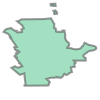

In [54]:
# wkt.loads(df.loc[1151, 'poly_wkt'])
df.loc[1576, 'poly_wkt']

# Сохранение

In [55]:
df.to_csv('../data/localities.csv', index = False)

# Проверка соответствия

In [12]:
df.loc[~df.address.astype(str).str.contains(('|').join(df.name))]

<ipython-input-12-a338ac617c34>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[~df.address.astype(str).str.contains(('|').join(df.name))]


,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly_wkt,poly,valid
427,Левый Сарам,участок сельский,Масляногорское муниципальное образов...,25210813003,150,Зиминский,10.19,Левый Сарам участок иркутская область,NaN,NaN,NaN,NaN,0


In [6]:
ind = []
import re
for i,r in df.iterrows():
    try:
        if re.search(r['name'].lower().strip(), r['address'].lower().strip()) == None:
            ind.append(i)
    except:
        continue

In [14]:
df.loc[ind][['name', 'address']]

,name,address
153,Артемовский,"Россия, Иркутская область, Бодайбинский район, рабочий посёлок Артёмовский"
176,Веселая Поляна,"Россия, Иркутская область, Боханский район, посёлок Весёлая Поляна"
272,Озерный,"Россия, Иркутская область, Братский район, посёлок Озёрный"
276,Подъвыездный,"Россия, Иркутская область, Братский район, поселок Подвыездный"
322,Молодежный,"Россия, Иркутская область, Жигаловский район, посёлок Молодёжный"
340,Бахвалово,"Россия, Иркутский район, садовые участки"
384,Семеновское,"Россия, Иркутская область, Заларинский район, село Семёновское"
389,Таежный,"Россия, Иркутская область, Заларинский район, участок Таёжный"
464,Березка,"Россия, Иркутский район, Большереченское муниципальное образование, посёлок Берёзка"
508,Молодежный,"Россия, Иркутский район, посёлок Молодёжный"


Поселок Бохвалово не имеет полигонов

In [60]:
df.loc[340, 'valid'] = 0